<a href="https://colab.research.google.com/github/vipashaaV321/User-Intent-Modeling/blob/main/LSTM_MR_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#0.5 , directional

Seed item: 713
Epoch 1/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.3340 - accuracy: 0.4172 - val_loss: 1.2592 - val_accuracy: 0.4419
Epoch 2/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2343 - accuracy: 0.4547 - val_loss: 1.2568 - val_accuracy: 0.4408
Epoch 3/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2181 - accuracy: 0.4631 - val_loss: 1.2610 - val_accuracy: 0.4413
Epoch 4/10
2500/2500 [==============================] - 4s 1ms/step - loss: 1.2100 - accuracy: 0.4674 - val_loss: 1.2657 - val_accuracy: 0.4401
Epoch 5/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2043 - accuracy: 0.4693 - val_loss: 1.2669 - val_accuracy: 0.4374
Epoch 6/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2003 - accuracy: 0.4721 - val_loss: 1.2672 - val_accuracy: 0.4419
Epoch 7/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.1971 - accuracy: 0.4728 - val_loss: 1.2693 

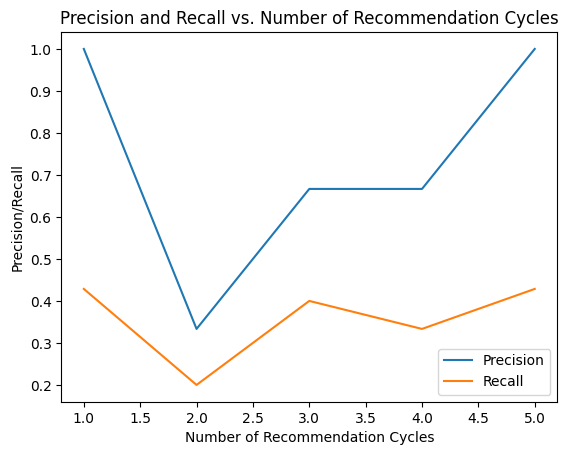

0.7333330888889703
0.35809517849434125


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split


class RecommenderLSTM:
    def __init__(self, num_users, num_items, embedding_dim):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

    def build_model(self):
        user_input = keras.Input(shape=(1,))
        item_input = keras.Input(shape=(1,))

        user_embedding = keras.layers.Embedding(self.num_users, self.embedding_dim)(user_input)
        item_embedding = keras.layers.Embedding(self.num_items, self.embedding_dim)(item_input)

        user_embedding = keras.layers.Flatten()(user_embedding)
        item_embedding = keras.layers.Flatten()(item_embedding)

        merged = keras.layers.Concatenate()([user_embedding, item_embedding])
        rnn_output = keras.layers.Dense(self.embedding_dim)(merged)
        output = keras.layers.Dense(10, activation='softmax')(rnn_output)

        model = keras.Model(inputs=[user_input, item_input], outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def train(self, train_data, epochs, batch_size):
        user_ids = train_data['user_id'].values - 1
        item_ids = train_data['item_id'].values - 1
        ratings = train_data['rating'].values

        user_train, user_val, item_train, item_val, rating_train, rating_val = train_test_split(
            user_ids, item_ids, ratings, test_size=0.2, random_state=42
        )
        train_labels_onehot = to_categorical(rating_train, num_classes=10)
        val_labels_onehot = to_categorical(rating_val, num_classes=10)

        model = self.build_model()

        model.fit([user_train, item_train], train_labels_onehot, epochs=epochs, batch_size=batch_size,
                  validation_data=([user_val, item_val],  val_labels_onehot))

        return model

    def recommend(self, user_id, model, top_n):
        user_ids = np.full(self.num_items, user_id - 1)
        item_ids = np.arange(self.num_items)

        predictions = model.predict([user_ids, item_ids]).flatten()

        top_indices = np.argsort(predictions)[::-1][:top_n]
        top_items = top_indices + 1  # Add 1 to adjust for 0-based indexing

        return top_items

class RecommenderSystem:
    def __init__(self, num_users, num_items):
        self.user_item_matrix = np.zeros((num_users, num_items))
        self.weights = np.zeros(num_items)
        self.user_preferences = np.zeros(num_items)

    def train(self, train_data, seed_item):
        for _, row in train_data.iterrows():
            user = row['user_id'] - 1
            item = row['item_id'] - 1
            rating = row['rating']
            self.user_item_matrix[user, item] = rating

        self.reweight(seed_item, [], 'Directional')

    def update_user_preferences(self, user, item, rating):
        self.user_preferences[item] = rating
        self.reweight(item, [], 'Directional')  # Update weights based on the new preference

    def recommend(self, seed_item, candidate_items, n):
        scores = np.zeros(len(candidate_items))

        for i, item in enumerate(candidate_items):
            overlap = self.calculate_overlap(seed_item, item)
            scores[i] = (1 - 0.5) * overlap + 0.5 * (overlap / len(candidate_items))

        sorted_indices = np.argsort(scores)[::-1]
        recommendations = [candidate_items[idx] for idx in sorted_indices[:n]]
        return recommendations

    def update_weights(self, seed_item, rejected_items, reweighting_policy):
        for item in rejected_items:
            if reweighting_policy == 'Directional':
                self.weights[item] += self.calculate_directional_delta(seed_item, item)
            elif reweighting_policy == 'Similarity':
                self.weights[item] += self.calculate_similarity_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Mean':
                self.weights[item] += self.calculate_similarity_mean_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Max':
                self.weights[item] += self.calculate_similarity_max_delta(seed_item, item)
            elif reweighting_policy == 'Recency':
                self.weights[item] += self.calculate_recency_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Mean':
                self.weights[item] += self.calculate_recency_mean_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Max':
                self.weights[item] += self.calculate_recency_max_delta(seed_item, item, len(rejected_items))

    def calculate_overlap(self, item1, item2):
        return np.dot(self.user_item_matrix[:, item1], self.user_item_matrix[:, item2])

    def calculate_directional_delta(self, seed_item, item):
        return self.calculate_overlap(seed_item, item)

    def calculate_similarity_delta(self, seed_item, item):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity * self.calculate_overlap(seed_item, item)

    def calculate_similarity_mean_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - mean_similarity

    def calculate_similarity_max_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - max_similarity

    def calculate_recency_delta(self, seed_item, item, depth):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity / depth - self.calculate_overlap(item, item)

    def calculate_recency_mean_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - mean_similarity

    def calculate_recency_max_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - max_similarity

    def reweight(self, seed_item, rejected_items, reweighting_policy):
        self.update_weights(seed_item, rejected_items, reweighting_policy)

    def generate_user_profile(self, user_id):
        user_ratings = self.user_item_matrix[user_id]
        liked_items = np.where(user_ratings > 3)[0]
        disliked_items = np.where(user_ratings < 3)[0]
        return liked_items, disliked_items


    def generate_recommendations(self, user_id, num_recommendation_cycles, num_recommendations):
      liked_items, disliked_items = self.generate_user_profile(user_id)
      seed_item = np.random.choice(liked_items)
      print(f"Seed item: {seed_item + 1}")

      data_path = '/content/u.data'
      columns = ['user_id', 'item_id', 'rating', 'timestamp']
      train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)

      # Define parameters
      num_users = train_data['user_id'].nunique()
      num_items = train_data['item_id'].nunique()
      embedding_dim = 32
      epochs = 10
      batch_size = 32
      num_recommendation_cycles = 5
      num_recommendations = 3
      selected_user_id = 22

      # Create and train the recommender LSTM
      recommender_lstm = RecommenderLSTM(num_users, num_items, embedding_dim)
      model = recommender_lstm.train(train_data, epochs, batch_size)

      # Generate recommendations for a specific user
      recommended_items = []
      for cycle in range(num_recommendation_cycles):
          recommendations = recommender_lstm.recommend(selected_user_id, model, num_recommendations)
          # print(f"Cycle {cycle + 1} Recommendations: {recommendations}")
          recommended_items.extend(recommendations)
          # Update user preferences and retrain the model if needed
          # ...

      recommended_items = recommended_items[:num_recommendation_cycles * num_recommendations]
      return recommended_items



    def evaluate_recommendation_quality(self, test_data, user_id, num_recommendation_cycles, num_recommendations):
        precision_list = []
        recall_list = []
        hitrate_list = []

        for _ in range(num_recommendation_cycles):
            liked_items, _ = self.generate_user_profile(user_id)
            seed_item = np.random.choice(liked_items)

            relevant_items = []

            for _ in range(num_recommendation_cycles):
                candidate_items = np.setdiff1d(liked_items, [seed_item])
                recommendations = self.recommend(seed_item, candidate_items, num_recommendations)
                relevant_items.extend(recommendations)
                seed_item = np.random.choice(np.setdiff1d(candidate_items, recommendations))

            relevant_items = list(set(relevant_items))
            recommended_items = self.recommend(seed_item, liked_items, num_recommendations)

            true_positives = len(set(recommended_items).intersection(relevant_items))
            false_positives = len(recommended_items) - true_positives
            false_negatives = len(relevant_items) - true_positives

            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)
            hitrate = true_positives / num_recommendations

            precision_list.append(precision)
            recall_list.append(recall)
            hitrate_list.append(hitrate)

        return precision_list, recall_list, hitrate_list

# Example usage
def main():
    # Load data


    data_path = '/content/u.data'
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    test_data= train_data.sample(frac=0.2, random_state=42) # Sample test data



    # Define parameters
    num_users = train_data['user_id'].nunique()
    num_items = train_data['item_id'].nunique()
    num_recommendation_cycles = 5
    num_recommendations = 3

    # Create and train the recommender system
    recommender = RecommenderSystem(num_users, num_items)
    recommender.train(train_data, seed_item=1)

    # Generate recommendations for a specific user
    user_id = 22
    recommender.generate_recommendations(user_id, num_recommendation_cycles, num_recommendations)

    # Evaluate recommendation quality
    precision_list, recall_list, hitrate_list = recommender.evaluate_recommendation_quality(test_data, user_id,
                                                                              num_recommendation_cycles,
                                                                              num_recommendations)

    # Print precision and recall for each cycle
    for i in range(num_recommendation_cycles):
        print(f"Cycle {i + 1} - Precision: {precision_list[i]}, Recall: {recall_list[i]}, Hit Rate: {hitrate_list[i]}")

    # Plot graph for number of recommendations cycle and precision/recall
    plt.plot(range(1, num_recommendation_cycles + 1), precision_list, label='Precision')
    plt.plot(range(1, num_recommendation_cycles + 1), recall_list, label='Recall')
    plt.plot(range(1, num_recommendation_cycles + 1), hitrate_list, label='Hitrate')
    plt.xlabel('Number of Recommendation Cycles')
    plt.ylabel('Precision/Recall')
    plt.title('Precision,Recall & Hitrate vs. Number of Recommendation Cycles')
    plt.legend()
    plt.show()
    print(sum(precision_list)/5)
    print(sum(recall_list)/5)
    print(sum(hitrate_list) / 5)

if __name__ == '__main__':
    main()


# eta =0.25

Seed item: 433
Epoch 1/10
2500/2500 [==============================] - 5s 2ms/step - loss: 1.3376 - accuracy: 0.4174 - val_loss: 1.2609 - val_accuracy: 0.4425
Epoch 2/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2350 - accuracy: 0.4559 - val_loss: 1.2565 - val_accuracy: 0.4426
Epoch 3/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2192 - accuracy: 0.4624 - val_loss: 1.2576 - val_accuracy: 0.4409
Epoch 4/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2108 - accuracy: 0.4670 - val_loss: 1.2630 - val_accuracy: 0.4390
Epoch 5/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2056 - accuracy: 0.4695 - val_loss: 1.2623 - val_accuracy: 0.4405
Epoch 6/10
2500/2500 [==============================] - 5s 2ms/step - loss: 1.2014 - accuracy: 0.4705 - val_loss: 1.2655 - val_accuracy: 0.4381
Epoch 7/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.1983 - accuracy: 0.4741 - val_loss: 1.2677 

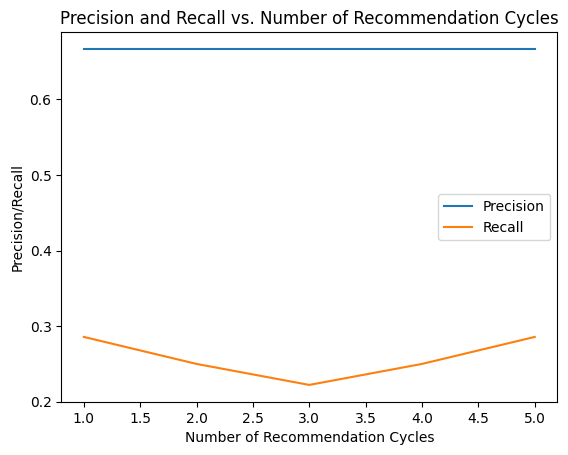

0.6666664444445185
0.25873012496536096


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split




class RecommenderLSTM:
    def __init__(self, num_users, num_items, embedding_dim):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

    def build_model(self):
        user_input = keras.Input(shape=(1,))
        item_input = keras.Input(shape=(1,))

        user_embedding = keras.layers.Embedding(self.num_users, self.embedding_dim)(user_input)
        item_embedding = keras.layers.Embedding(self.num_items, self.embedding_dim)(item_input)

        user_embedding = keras.layers.Flatten()(user_embedding)
        item_embedding = keras.layers.Flatten()(item_embedding)

        merged = keras.layers.Concatenate()([user_embedding, item_embedding])
        rnn_output = keras.layers.Dense(self.embedding_dim)(merged)
        output = keras.layers.Dense(10, activation='softmax')(rnn_output)

        model = keras.Model(inputs=[user_input, item_input], outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def train(self, train_data, epochs, batch_size):
        user_ids = train_data['user_id'].values - 1
        item_ids = train_data['item_id'].values - 1
        ratings = train_data['rating'].values

        user_train, user_val, item_train, item_val, rating_train, rating_val = train_test_split(
            user_ids, item_ids, ratings, test_size=0.2, random_state=42
        )
        train_labels_onehot = to_categorical(rating_train, num_classes=10)
        val_labels_onehot = to_categorical(rating_val, num_classes=10)

        model = self.build_model()

        model.fit([user_train, item_train], train_labels_onehot, epochs=epochs, batch_size=batch_size,
                  validation_data=([user_val, item_val],  val_labels_onehot))

        return model

    def recommend(self, user_id, model, top_n):
        user_ids = np.full(self.num_items, user_id - 1)
        item_ids = np.arange(self.num_items)

        predictions = model.predict([user_ids, item_ids]).flatten()

        top_indices = np.argsort(predictions)[::-1][:top_n]
        top_items = top_indices + 1  # Add 1 to adjust for 0-based indexing

        return top_items

class RecommenderSystem:
    def __init__(self, num_users, num_items):
        self.user_item_matrix = np.zeros((num_users, num_items))
        self.weights = np.zeros(num_items)
        self.user_preferences = np.zeros(num_items)

    def train(self, train_data, seed_item):
        for _, row in train_data.iterrows():
            user = row['user_id'] - 1
            item = row['item_id'] - 1
            rating = row['rating']
            self.user_item_matrix[user, item] = rating

        self.reweight(seed_item, [], 'Directional')

    def update_user_preferences(self, user, item, rating):
        self.user_preferences[item] = rating
        self.reweight(item, [], 'Directional')  # Update weights based on the new preference

    def recommend(self, seed_item, candidate_items, n):
        scores = np.zeros(len(candidate_items))

        for i, item in enumerate(candidate_items):
            overlap = self.calculate_overlap(seed_item, item)
            scores[i] = (1 - 0.25) * overlap + 0.25 * (overlap / len(candidate_items))

        sorted_indices = np.argsort(scores)[::-1]
        recommendations = [candidate_items[idx] for idx in sorted_indices[:n]]
        return recommendations

    def update_weights(self, seed_item, rejected_items, reweighting_policy):
        for item in rejected_items:
            if reweighting_policy == 'Directional':
                self.weights[item] += self.calculate_directional_delta(seed_item, item)
            elif reweighting_policy == 'Similarity':
                self.weights[item] += self.calculate_similarity_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Mean':
                self.weights[item] += self.calculate_similarity_mean_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Max':
                self.weights[item] += self.calculate_similarity_max_delta(seed_item, item)
            elif reweighting_policy == 'Recency':
                self.weights[item] += self.calculate_recency_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Mean':
                self.weights[item] += self.calculate_recency_mean_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Max':
                self.weights[item] += self.calculate_recency_max_delta(seed_item, item, len(rejected_items))

    def calculate_overlap(self, item1, item2):
        return np.dot(self.user_item_matrix[:, item1], self.user_item_matrix[:, item2])

    def calculate_directional_delta(self, seed_item, item):
        return self.calculate_overlap(seed_item, item)

    def calculate_similarity_delta(self, seed_item, item):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity * self.calculate_overlap(seed_item, item)

    def calculate_similarity_mean_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - mean_similarity

    def calculate_similarity_max_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - max_similarity

    def calculate_recency_delta(self, seed_item, item, depth):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity / depth - self.calculate_overlap(item, item)

    def calculate_recency_mean_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - mean_similarity

    def calculate_recency_max_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - max_similarity

    def reweight(self, seed_item, rejected_items, reweighting_policy):
        self.update_weights(seed_item, rejected_items, reweighting_policy)

    def generate_user_profile(self, user_id):
        user_ratings = self.user_item_matrix[user_id]
        liked_items = np.where(user_ratings > 3)[0]
        disliked_items = np.where(user_ratings < 3)[0]
        return liked_items, disliked_items


    def generate_recommendations(self, user_id, num_recommendation_cycles, num_recommendations):
      liked_items, disliked_items = self.generate_user_profile(user_id)
      seed_item = np.random.choice(liked_items)
      print(f"Seed item: {seed_item + 1}")

      data_path = '/content/u.data'
      columns = ['user_id', 'item_id', 'rating', 'timestamp']
      train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)

      # Define parameters
      num_users = train_data['user_id'].nunique()
      num_items = train_data['item_id'].nunique()
      embedding_dim = 32
      epochs = 10
      batch_size = 32
      num_recommendation_cycles = 5
      num_recommendations = 3
      selected_user_id = 22

      # Create and train the recommender LSTM
      recommender_lstm = RecommenderLSTM(num_users, num_items, embedding_dim)
      model = recommender_lstm.train(train_data, epochs, batch_size)

      # Generate recommendations for a specific user
      recommended_items = []
      for cycle in range(num_recommendation_cycles):
          recommendations = recommender_lstm.recommend(selected_user_id, model, num_recommendations)
          # print(f"Cycle {cycle + 1} Recommendations: {recommendations}")
          recommended_items.extend(recommendations)
          # Update user preferences and retrain the model if needed
          # ...

      recommended_items = recommended_items[:num_recommendation_cycles * num_recommendations]
      return recommended_items



    def evaluate_recommendation_quality(self, test_data, user_id, num_recommendation_cycles, num_recommendations):
        precision_list = []
        recall_list = []

        for _ in range(num_recommendation_cycles):
            liked_items, _ = self.generate_user_profile(user_id)
            seed_item = np.random.choice(liked_items)

            relevant_items = []

            for _ in range(num_recommendation_cycles):
                candidate_items = np.setdiff1d(liked_items, [seed_item])
                recommendations = self.recommend(seed_item, candidate_items, num_recommendations)
                relevant_items.extend(recommendations)
                seed_item = np.random.choice(np.setdiff1d(candidate_items, recommendations))

            relevant_items = list(set(relevant_items))
            recommended_items = self.recommend(seed_item, liked_items, num_recommendations)

            true_positives = len(set(recommended_items).intersection(relevant_items))
            false_positives = len(recommended_items) - true_positives
            false_negatives = len(relevant_items) - true_positives

            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)

            precision_list.append(precision)
            recall_list.append(recall)

        return precision_list, recall_list

# Example usage
def main():
    # Load data


    data_path = '/content/u.data'
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    test_data= train_data.sample(frac=0.2, random_state=42) # Sample test data



    # Define parameters
    num_users = train_data['user_id'].nunique()
    num_items = train_data['item_id'].nunique()
    num_recommendation_cycles = 5
    num_recommendations = 3

    # Create and train the recommender system
    recommender = RecommenderSystem(num_users, num_items)
    recommender.train(train_data, seed_item=1)

    # Generate recommendations for a specific user
    user_id = 22
    recommender.generate_recommendations(user_id, num_recommendation_cycles, num_recommendations)

    # Evaluate recommendation quality
    precision_list, recall_list = recommender.evaluate_recommendation_quality(test_data, user_id,
                                                                              num_recommendation_cycles,
                                                                              num_recommendations)

    # Print precision and recall for each cycle
    for i in range(num_recommendation_cycles):
        print(f"Cycle {i + 1} - Precision: {precision_list[i]}, Recall: {recall_list[i]}")

    # Plot graph for number of recommendations cycle and precision/recall
    plt.plot(range(1, num_recommendation_cycles + 1), precision_list, label='Precision')
    plt.plot(range(1, num_recommendation_cycles + 1), recall_list, label='Recall')
    plt.xlabel('Number of Recommendation Cycles')
    plt.ylabel('Precision/Recall')
    plt.title('Precision and Recall vs. Number of Recommendation Cycles')
    plt.legend()
    plt.show()
    print(sum(precision_list)/5)
    print(sum(recall_list)/5)

if __name__ == '__main__':
    main()


# 0

Seed item: 224
Epoch 1/10
2500/2500 [==============================] - 5s 2ms/step - loss: 1.3343 - accuracy: 0.4171 - val_loss: 1.2598 - val_accuracy: 0.4424
Epoch 2/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2356 - accuracy: 0.4557 - val_loss: 1.2571 - val_accuracy: 0.4389
Epoch 3/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2190 - accuracy: 0.4625 - val_loss: 1.2593 - val_accuracy: 0.4428
Epoch 4/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2107 - accuracy: 0.4666 - val_loss: 1.2642 - val_accuracy: 0.4374
Epoch 5/10
2500/2500 [==============================] - 5s 2ms/step - loss: 1.2048 - accuracy: 0.4693 - val_loss: 1.2672 - val_accuracy: 0.4358
Epoch 6/10
2500/2500 [==============================] - 7s 3ms/step - loss: 1.2006 - accuracy: 0.4706 - val_loss: 1.2676 - val_accuracy: 0.4396
Epoch 7/10
2500/2500 [==============================] - 6s 3ms/step - loss: 1.1970 - accuracy: 0.4735 - val_loss: 1.2718 

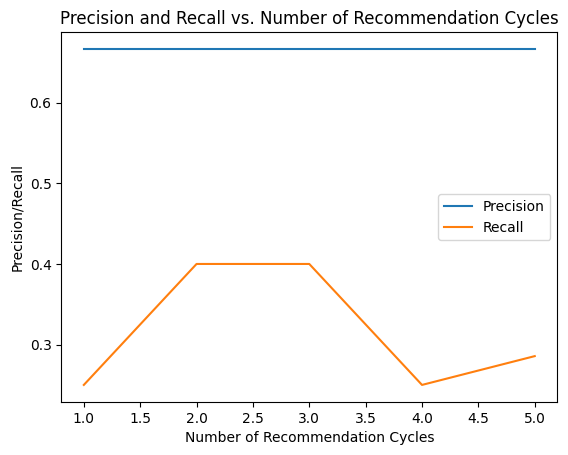

0.6666664444445185
0.31714280447960097


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split




class RecommenderLSTM:
    def __init__(self, num_users, num_items, embedding_dim):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

    def build_model(self):
        user_input = keras.Input(shape=(1,))
        item_input = keras.Input(shape=(1,))

        user_embedding = keras.layers.Embedding(self.num_users, self.embedding_dim)(user_input)
        item_embedding = keras.layers.Embedding(self.num_items, self.embedding_dim)(item_input)

        user_embedding = keras.layers.Flatten()(user_embedding)
        item_embedding = keras.layers.Flatten()(item_embedding)

        merged = keras.layers.Concatenate()([user_embedding, item_embedding])
        rnn_output = keras.layers.Dense(self.embedding_dim)(merged)
        output = keras.layers.Dense(10, activation='softmax')(rnn_output)

        model = keras.Model(inputs=[user_input, item_input], outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def train(self, train_data, epochs, batch_size):
        user_ids = train_data['user_id'].values - 1
        item_ids = train_data['item_id'].values - 1
        ratings = train_data['rating'].values

        user_train, user_val, item_train, item_val, rating_train, rating_val = train_test_split(
            user_ids, item_ids, ratings, test_size=0.2, random_state=42
        )
        train_labels_onehot = to_categorical(rating_train, num_classes=10)
        val_labels_onehot = to_categorical(rating_val, num_classes=10)

        model = self.build_model()

        model.fit([user_train, item_train], train_labels_onehot, epochs=epochs, batch_size=batch_size,
                  validation_data=([user_val, item_val],  val_labels_onehot))

        return model

    def recommend(self, user_id, model, top_n):
        user_ids = np.full(self.num_items, user_id - 1)
        item_ids = np.arange(self.num_items)

        predictions = model.predict([user_ids, item_ids]).flatten()

        top_indices = np.argsort(predictions)[::-1][:top_n]
        top_items = top_indices + 1  # Add 1 to adjust for 0-based indexing

        return top_items

class RecommenderSystem:
    def __init__(self, num_users, num_items):
        self.user_item_matrix = np.zeros((num_users, num_items))
        self.weights = np.zeros(num_items)
        self.user_preferences = np.zeros(num_items)

    def train(self, train_data, seed_item):
        for _, row in train_data.iterrows():
            user = row['user_id'] - 1
            item = row['item_id'] - 1
            rating = row['rating']
            self.user_item_matrix[user, item] = rating

        self.reweight(seed_item, [], 'Directional')

    def update_user_preferences(self, user, item, rating):
        self.user_preferences[item] = rating
        self.reweight(item, [], 'Directional')  # Update weights based on the new preference

    def recommend(self, seed_item, candidate_items, n):
        scores = np.zeros(len(candidate_items))

        for i, item in enumerate(candidate_items):
            overlap = self.calculate_overlap(seed_item, item)
            scores[i] = (1 - 0) * overlap + 0 * (overlap / len(candidate_items))

        sorted_indices = np.argsort(scores)[::-1]
        recommendations = [candidate_items[idx] for idx in sorted_indices[:n]]
        return recommendations

    def update_weights(self, seed_item, rejected_items, reweighting_policy):
        for item in rejected_items:
            if reweighting_policy == 'Directional':
                self.weights[item] += self.calculate_directional_delta(seed_item, item)
            elif reweighting_policy == 'Similarity':
                self.weights[item] += self.calculate_similarity_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Mean':
                self.weights[item] += self.calculate_similarity_mean_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Max':
                self.weights[item] += self.calculate_similarity_max_delta(seed_item, item)
            elif reweighting_policy == 'Recency':
                self.weights[item] += self.calculate_recency_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Mean':
                self.weights[item] += self.calculate_recency_mean_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Max':
                self.weights[item] += self.calculate_recency_max_delta(seed_item, item, len(rejected_items))

    def calculate_overlap(self, item1, item2):
        return np.dot(self.user_item_matrix[:, item1], self.user_item_matrix[:, item2])

    def calculate_directional_delta(self, seed_item, item):
        return self.calculate_overlap(seed_item, item)

    def calculate_similarity_delta(self, seed_item, item):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity * self.calculate_overlap(seed_item, item)

    def calculate_similarity_mean_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - mean_similarity

    def calculate_similarity_max_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - max_similarity

    def calculate_recency_delta(self, seed_item, item, depth):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity / depth - self.calculate_overlap(item, item)

    def calculate_recency_mean_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - mean_similarity

    def calculate_recency_max_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - max_similarity

    def reweight(self, seed_item, rejected_items, reweighting_policy):
        self.update_weights(seed_item, rejected_items, reweighting_policy)

    def generate_user_profile(self, user_id):
        user_ratings = self.user_item_matrix[user_id]
        liked_items = np.where(user_ratings > 3)[0]
        disliked_items = np.where(user_ratings < 3)[0]
        return liked_items, disliked_items


    def generate_recommendations(self, user_id, num_recommendation_cycles, num_recommendations):
      liked_items, disliked_items = self.generate_user_profile(user_id)
      seed_item = np.random.choice(liked_items)
      print(f"Seed item: {seed_item + 1}")

      data_path = '/content/u.data'
      columns = ['user_id', 'item_id', 'rating', 'timestamp']
      train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)

      # Define parameters
      num_users = train_data['user_id'].nunique()
      num_items = train_data['item_id'].nunique()
      embedding_dim = 32
      epochs = 10
      batch_size = 32
      num_recommendation_cycles = 5
      num_recommendations = 3
      selected_user_id = 22

      # Create and train the recommender LSTM
      recommender_lstm = RecommenderLSTM(num_users, num_items, embedding_dim)
      model = recommender_lstm.train(train_data, epochs, batch_size)

      # Generate recommendations for a specific user
      recommended_items = []
      for cycle in range(num_recommendation_cycles):
          recommendations = recommender_lstm.recommend(selected_user_id, model, num_recommendations)
          # print(f"Cycle {cycle + 1} Recommendations: {recommendations}")
          recommended_items.extend(recommendations)
          # Update user preferences and retrain the model if needed
          # ...

      recommended_items = recommended_items[:num_recommendation_cycles * num_recommendations]
      return recommended_items



    def evaluate_recommendation_quality(self, test_data, user_id, num_recommendation_cycles, num_recommendations):
        precision_list = []
        recall_list = []

        for _ in range(num_recommendation_cycles):
            liked_items, _ = self.generate_user_profile(user_id)
            seed_item = np.random.choice(liked_items)

            relevant_items = []

            for _ in range(num_recommendation_cycles):
                candidate_items = np.setdiff1d(liked_items, [seed_item])
                recommendations = self.recommend(seed_item, candidate_items, num_recommendations)
                relevant_items.extend(recommendations)
                seed_item = np.random.choice(np.setdiff1d(candidate_items, recommendations))

            relevant_items = list(set(relevant_items))
            recommended_items = self.recommend(seed_item, liked_items, num_recommendations)

            true_positives = len(set(recommended_items).intersection(relevant_items))
            false_positives = len(recommended_items) - true_positives
            false_negatives = len(relevant_items) - true_positives

            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)

            precision_list.append(precision)
            recall_list.append(recall)

        return precision_list, recall_list

# Example usage
def main():
    # Load data


    data_path = '/content/u.data'
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    test_data= train_data.sample(frac=0.2, random_state=42) # Sample test data



    # Define parameters
    num_users = train_data['user_id'].nunique()
    num_items = train_data['item_id'].nunique()
    num_recommendation_cycles = 5
    num_recommendations = 3

    # Create and train the recommender system
    recommender = RecommenderSystem(num_users, num_items)
    recommender.train(train_data, seed_item=1)

    # Generate recommendations for a specific user
    user_id = 22
    recommender.generate_recommendations(user_id, num_recommendation_cycles, num_recommendations)

    # Evaluate recommendation quality
    precision_list, recall_list = recommender.evaluate_recommendation_quality(test_data, user_id,
                                                                              num_recommendation_cycles,
                                                                              num_recommendations)

    # Print precision and recall for each cycle
    for i in range(num_recommendation_cycles):
        print(f"Cycle {i + 1} - Precision: {precision_list[i]}, Recall: {recall_list[i]}")

    # Plot graph for number of recommendations cycle and precision/recall
    plt.plot(range(1, num_recommendation_cycles + 1), precision_list, label='Precision')
    plt.plot(range(1, num_recommendation_cycles + 1), recall_list, label='Recall')
    plt.xlabel('Number of Recommendation Cycles')
    plt.ylabel('Precision/Recall')
    plt.title('Precision and Recall vs. Number of Recommendation Cycles')
    plt.legend()
    plt.show()
    print(sum(precision_list)/5)
    print(sum(recall_list)/5)

if __name__ == '__main__':
    main()


#1

Seed item: 230
Epoch 1/10
2500/2500 [==============================] - 5s 2ms/step - loss: 1.3368 - accuracy: 0.4180 - val_loss: 1.2600 - val_accuracy: 0.4393
Epoch 2/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2350 - accuracy: 0.4534 - val_loss: 1.2553 - val_accuracy: 0.4421
Epoch 3/10
2500/2500 [==============================] - 4s 1ms/step - loss: 1.2189 - accuracy: 0.4628 - val_loss: 1.2596 - val_accuracy: 0.4416
Epoch 4/10
2500/2500 [==============================] - 5s 2ms/step - loss: 1.2109 - accuracy: 0.4668 - val_loss: 1.2624 - val_accuracy: 0.4416
Epoch 5/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2055 - accuracy: 0.4691 - val_loss: 1.2645 - val_accuracy: 0.4428
Epoch 6/10
2500/2500 [==============================] - 4s 1ms/step - loss: 1.2011 - accuracy: 0.4715 - val_loss: 1.2667 - val_accuracy: 0.4379
Epoch 7/10
2500/2500 [==============================] - 5s 2ms/step - loss: 1.1982 - accuracy: 0.4732 - val_loss: 1.2679 

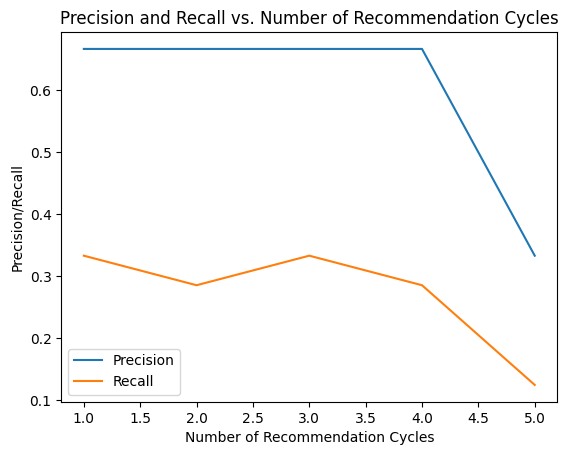

0.5999998000000667
0.2726190059453012


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split




class RecommenderLSTM:
    def __init__(self, num_users, num_items, embedding_dim):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

    def build_model(self):
        user_input = keras.Input(shape=(1,))
        item_input = keras.Input(shape=(1,))

        user_embedding = keras.layers.Embedding(self.num_users, self.embedding_dim)(user_input)
        item_embedding = keras.layers.Embedding(self.num_items, self.embedding_dim)(item_input)

        user_embedding = keras.layers.Flatten()(user_embedding)
        item_embedding = keras.layers.Flatten()(item_embedding)

        merged = keras.layers.Concatenate()([user_embedding, item_embedding])
        rnn_output = keras.layers.Dense(self.embedding_dim)(merged)
        output = keras.layers.Dense(10, activation='softmax')(rnn_output)

        model = keras.Model(inputs=[user_input, item_input], outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def train(self, train_data, epochs, batch_size):
        user_ids = train_data['user_id'].values - 1
        item_ids = train_data['item_id'].values - 1
        ratings = train_data['rating'].values

        user_train, user_val, item_train, item_val, rating_train, rating_val = train_test_split(
            user_ids, item_ids, ratings, test_size=0.2, random_state=42
        )
        train_labels_onehot = to_categorical(rating_train, num_classes=10)
        val_labels_onehot = to_categorical(rating_val, num_classes=10)

        model = self.build_model()

        model.fit([user_train, item_train], train_labels_onehot, epochs=epochs, batch_size=batch_size,
                  validation_data=([user_val, item_val],  val_labels_onehot))

        return model

    def recommend(self, user_id, model, top_n):
        user_ids = np.full(self.num_items, user_id - 1)
        item_ids = np.arange(self.num_items)

        predictions = model.predict([user_ids, item_ids]).flatten()

        top_indices = np.argsort(predictions)[::-1][:top_n]
        top_items = top_indices + 1  # Add 1 to adjust for 0-based indexing

        return top_items

class RecommenderSystem:
    def __init__(self, num_users, num_items):
        self.user_item_matrix = np.zeros((num_users, num_items))
        self.weights = np.zeros(num_items)
        self.user_preferences = np.zeros(num_items)

    def train(self, train_data, seed_item):
        for _, row in train_data.iterrows():
            user = row['user_id'] - 1
            item = row['item_id'] - 1
            rating = row['rating']
            self.user_item_matrix[user, item] = rating

        self.reweight(seed_item, [], 'Directional')

    def update_user_preferences(self, user, item, rating):
        self.user_preferences[item] = rating
        self.reweight(item, [], 'Directional')  # Update weights based on the new preference

    def recommend(self, seed_item, candidate_items, n):
        scores = np.zeros(len(candidate_items))

        for i, item in enumerate(candidate_items):
            overlap = self.calculate_overlap(seed_item, item)
            scores[i] = (1 - 1) * overlap + 1 * (overlap / len(candidate_items))

        sorted_indices = np.argsort(scores)[::-1]
        recommendations = [candidate_items[idx] for idx in sorted_indices[:n]]
        return recommendations

    def update_weights(self, seed_item, rejected_items, reweighting_policy):
        for item in rejected_items:
            if reweighting_policy == 'Directional':
                self.weights[item] += self.calculate_directional_delta(seed_item, item)
            elif reweighting_policy == 'Similarity':
                self.weights[item] += self.calculate_similarity_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Mean':
                self.weights[item] += self.calculate_similarity_mean_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Max':
                self.weights[item] += self.calculate_similarity_max_delta(seed_item, item)
            elif reweighting_policy == 'Recency':
                self.weights[item] += self.calculate_recency_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Mean':
                self.weights[item] += self.calculate_recency_mean_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Max':
                self.weights[item] += self.calculate_recency_max_delta(seed_item, item, len(rejected_items))

    def calculate_overlap(self, item1, item2):
        return np.dot(self.user_item_matrix[:, item1], self.user_item_matrix[:, item2])

    def calculate_directional_delta(self, seed_item, item):
        return self.calculate_overlap(seed_item, item)

    def calculate_similarity_delta(self, seed_item, item):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity * self.calculate_overlap(seed_item, item)

    def calculate_similarity_mean_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - mean_similarity

    def calculate_similarity_max_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - max_similarity

    def calculate_recency_delta(self, seed_item, item, depth):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity / depth - self.calculate_overlap(item, item)

    def calculate_recency_mean_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - mean_similarity

    def calculate_recency_max_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - max_similarity

    def reweight(self, seed_item, rejected_items, reweighting_policy):
        self.update_weights(seed_item, rejected_items, reweighting_policy)

    def generate_user_profile(self, user_id):
        user_ratings = self.user_item_matrix[user_id]
        liked_items = np.where(user_ratings > 3)[0]
        disliked_items = np.where(user_ratings < 3)[0]
        return liked_items, disliked_items


    def generate_recommendations(self, user_id, num_recommendation_cycles, num_recommendations):
      liked_items, disliked_items = self.generate_user_profile(user_id)
      seed_item = np.random.choice(liked_items)
      print(f"Seed item: {seed_item + 1}")

      data_path = '/content/u.data'
      columns = ['user_id', 'item_id', 'rating', 'timestamp']
      train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)

      # Define parameters
      num_users = train_data['user_id'].nunique()
      num_items = train_data['item_id'].nunique()
      embedding_dim = 32
      epochs = 10
      batch_size = 32
      num_recommendation_cycles = 5
      num_recommendations = 3
      selected_user_id = 22

      # Create and train the recommender LSTM
      recommender_lstm = RecommenderLSTM(num_users, num_items, embedding_dim)
      model = recommender_lstm.train(train_data, epochs, batch_size)

      # Generate recommendations for a specific user
      recommended_items = []
      for cycle in range(num_recommendation_cycles):
          recommendations = recommender_lstm.recommend(selected_user_id, model, num_recommendations)
          # print(f"Cycle {cycle + 1} Recommendations: {recommendations}")
          recommended_items.extend(recommendations)
          # Update user preferences and retrain the model if needed
          # ...

      recommended_items = recommended_items[:num_recommendation_cycles * num_recommendations]
      return recommended_items



    def evaluate_recommendation_quality(self, test_data, user_id, num_recommendation_cycles, num_recommendations):
        precision_list = []
        recall_list = []

        for _ in range(num_recommendation_cycles):
            liked_items, _ = self.generate_user_profile(user_id)
            seed_item = np.random.choice(liked_items)

            relevant_items = []

            for _ in range(num_recommendation_cycles):
                candidate_items = np.setdiff1d(liked_items, [seed_item])
                recommendations = self.recommend(seed_item, candidate_items, num_recommendations)
                relevant_items.extend(recommendations)
                seed_item = np.random.choice(np.setdiff1d(candidate_items, recommendations))

            relevant_items = list(set(relevant_items))
            recommended_items = self.recommend(seed_item, liked_items, num_recommendations)

            true_positives = len(set(recommended_items).intersection(relevant_items))
            false_positives = len(recommended_items) - true_positives
            false_negatives = len(relevant_items) - true_positives

            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)

            precision_list.append(precision)
            recall_list.append(recall)

        return precision_list, recall_list

# Example usage
def main():
    # Load data


    data_path = '/content/u.data'
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    test_data= train_data.sample(frac=0.2, random_state=42) # Sample test data



    # Define parameters
    num_users = train_data['user_id'].nunique()
    num_items = train_data['item_id'].nunique()
    num_recommendation_cycles = 5
    num_recommendations = 3

    # Create and train the recommender system
    recommender = RecommenderSystem(num_users, num_items)
    recommender.train(train_data, seed_item=1)

    # Generate recommendations for a specific user
    user_id = 22
    recommender.generate_recommendations(user_id, num_recommendation_cycles, num_recommendations)

    # Evaluate recommendation quality
    precision_list, recall_list = recommender.evaluate_recommendation_quality(test_data, user_id,
                                                                              num_recommendation_cycles,
                                                                              num_recommendations)

    # Print precision and recall for each cycle
    for i in range(num_recommendation_cycles):
        print(f"Cycle {i + 1} - Precision: {precision_list[i]}, Recall: {recall_list[i]}")

    # Plot graph for number of recommendations cycle and precision/recall
    plt.plot(range(1, num_recommendation_cycles + 1), precision_list, label='Precision')
    plt.plot(range(1, num_recommendation_cycles + 1), recall_list, label='Recall')
    plt.xlabel('Number of Recommendation Cycles')
    plt.ylabel('Precision/Recall')
    plt.title('Precision and Recall vs. Number of Recommendation Cycles')
    plt.legend()
    plt.show()
    print(sum(precision_list)/5)
    print(sum(recall_list)/5)

if __name__ == '__main__':
    main()


# 0.75

Seed item: 55
Epoch 1/10
2500/2500 [==============================] - 5s 2ms/step - loss: 1.3320 - accuracy: 0.4187 - val_loss: 1.2609 - val_accuracy: 0.4386
Epoch 2/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2358 - accuracy: 0.4528 - val_loss: 1.2571 - val_accuracy: 0.4437
Epoch 3/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2194 - accuracy: 0.4623 - val_loss: 1.2630 - val_accuracy: 0.4411
Epoch 4/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2107 - accuracy: 0.4671 - val_loss: 1.2654 - val_accuracy: 0.4392
Epoch 5/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2053 - accuracy: 0.4710 - val_loss: 1.2685 - val_accuracy: 0.4382
Epoch 6/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2008 - accuracy: 0.4720 - val_loss: 1.2666 - val_accuracy: 0.4417
Epoch 7/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.1981 - accuracy: 0.4708 - val_loss: 1.2683 -

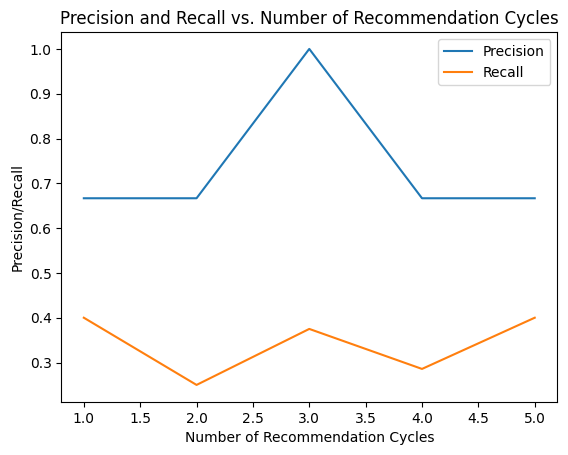

0.7333330888889703
0.3421428013546014


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split




class RecommenderLSTM:
    def __init__(self, num_users, num_items, embedding_dim):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

    def build_model(self):
        user_input = keras.Input(shape=(1,))
        item_input = keras.Input(shape=(1,))

        user_embedding = keras.layers.Embedding(self.num_users, self.embedding_dim)(user_input)
        item_embedding = keras.layers.Embedding(self.num_items, self.embedding_dim)(item_input)

        user_embedding = keras.layers.Flatten()(user_embedding)
        item_embedding = keras.layers.Flatten()(item_embedding)

        merged = keras.layers.Concatenate()([user_embedding, item_embedding])
        rnn_output = keras.layers.Dense(self.embedding_dim)(merged)
        output = keras.layers.Dense(10, activation='softmax')(rnn_output)

        model = keras.Model(inputs=[user_input, item_input], outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def train(self, train_data, epochs, batch_size):
        user_ids = train_data['user_id'].values - 1
        item_ids = train_data['item_id'].values - 1
        ratings = train_data['rating'].values

        user_train, user_val, item_train, item_val, rating_train, rating_val = train_test_split(
            user_ids, item_ids, ratings, test_size=0.2, random_state=42
        )
        train_labels_onehot = to_categorical(rating_train, num_classes=10)
        val_labels_onehot = to_categorical(rating_val, num_classes=10)

        model = self.build_model()

        model.fit([user_train, item_train], train_labels_onehot, epochs=epochs, batch_size=batch_size,
                  validation_data=([user_val, item_val],  val_labels_onehot))

        return model

    def recommend(self, user_id, model, top_n):
        user_ids = np.full(self.num_items, user_id - 1)
        item_ids = np.arange(self.num_items)

        predictions = model.predict([user_ids, item_ids]).flatten()

        top_indices = np.argsort(predictions)[::-1][:top_n]
        top_items = top_indices + 1  # Add 1 to adjust for 0-based indexing

        return top_items

class RecommenderSystem:
    def __init__(self, num_users, num_items):
        self.user_item_matrix = np.zeros((num_users, num_items))
        self.weights = np.zeros(num_items)
        self.user_preferences = np.zeros(num_items)

    def train(self, train_data, seed_item):
        for _, row in train_data.iterrows():
            user = row['user_id'] - 1
            item = row['item_id'] - 1
            rating = row['rating']
            self.user_item_matrix[user, item] = rating

        self.reweight(seed_item, [], 'Directional')

    def update_user_preferences(self, user, item, rating):
        self.user_preferences[item] = rating
        self.reweight(item, [], 'Directional')  # Update weights based on the new preference

    def recommend(self, seed_item, candidate_items, n):
        scores = np.zeros(len(candidate_items))

        for i, item in enumerate(candidate_items):
            overlap = self.calculate_overlap(seed_item, item)
            scores[i] = (1 - 0.75) * overlap + 0.75 * (overlap / len(candidate_items))

        sorted_indices = np.argsort(scores)[::-1]
        recommendations = [candidate_items[idx] for idx in sorted_indices[:n]]
        return recommendations

    def update_weights(self, seed_item, rejected_items, reweighting_policy):
        for item in rejected_items:
            if reweighting_policy == 'Directional':
                self.weights[item] += self.calculate_directional_delta(seed_item, item)
            elif reweighting_policy == 'Similarity':
                self.weights[item] += self.calculate_similarity_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Mean':
                self.weights[item] += self.calculate_similarity_mean_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Max':
                self.weights[item] += self.calculate_similarity_max_delta(seed_item, item)
            elif reweighting_policy == 'Recency':
                self.weights[item] += self.calculate_recency_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Mean':
                self.weights[item] += self.calculate_recency_mean_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Max':
                self.weights[item] += self.calculate_recency_max_delta(seed_item, item, len(rejected_items))

    def calculate_overlap(self, item1, item2):
        return np.dot(self.user_item_matrix[:, item1], self.user_item_matrix[:, item2])

    def calculate_directional_delta(self, seed_item, item):
        return self.calculate_overlap(seed_item, item)

    def calculate_similarity_delta(self, seed_item, item):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity * self.calculate_overlap(seed_item, item)

    def calculate_similarity_mean_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - mean_similarity

    def calculate_similarity_max_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - max_similarity

    def calculate_recency_delta(self, seed_item, item, depth):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity / depth - self.calculate_overlap(item, item)

    def calculate_recency_mean_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - mean_similarity

    def calculate_recency_max_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - max_similarity

    def reweight(self, seed_item, rejected_items, reweighting_policy):
        self.update_weights(seed_item, rejected_items, reweighting_policy)

    def generate_user_profile(self, user_id):
        user_ratings = self.user_item_matrix[user_id]
        liked_items = np.where(user_ratings > 3)[0]
        disliked_items = np.where(user_ratings < 3)[0]
        return liked_items, disliked_items


    def generate_recommendations(self, user_id, num_recommendation_cycles, num_recommendations):
      liked_items, disliked_items = self.generate_user_profile(user_id)
      seed_item = np.random.choice(liked_items)
      print(f"Seed item: {seed_item + 1}")

      data_path = '/content/u.data'
      columns = ['user_id', 'item_id', 'rating', 'timestamp']
      train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)

      # Define parameters
      num_users = train_data['user_id'].nunique()
      num_items = train_data['item_id'].nunique()
      embedding_dim = 32
      epochs = 10
      batch_size = 32
      num_recommendation_cycles = 5
      num_recommendations = 3
      selected_user_id = 22

      # Create and train the recommender LSTM
      recommender_lstm = RecommenderLSTM(num_users, num_items, embedding_dim)
      model = recommender_lstm.train(train_data, epochs, batch_size)

      # Generate recommendations for a specific user
      recommended_items = []
      for cycle in range(num_recommendation_cycles):
          recommendations = recommender_lstm.recommend(selected_user_id, model, num_recommendations)
          # print(f"Cycle {cycle + 1} Recommendations: {recommendations}")
          recommended_items.extend(recommendations)
          # Update user preferences and retrain the model if needed
          # ...

      recommended_items = recommended_items[:num_recommendation_cycles * num_recommendations]
      return recommended_items



    def evaluate_recommendation_quality(self, test_data, user_id, num_recommendation_cycles, num_recommendations):
        precision_list = []
        recall_list = []

        for _ in range(num_recommendation_cycles):
            liked_items, _ = self.generate_user_profile(user_id)
            seed_item = np.random.choice(liked_items)

            relevant_items = []

            for _ in range(num_recommendation_cycles):
                candidate_items = np.setdiff1d(liked_items, [seed_item])
                recommendations = self.recommend(seed_item, candidate_items, num_recommendations)
                relevant_items.extend(recommendations)
                seed_item = np.random.choice(np.setdiff1d(candidate_items, recommendations))

            relevant_items = list(set(relevant_items))
            recommended_items = self.recommend(seed_item, liked_items, num_recommendations)

            true_positives = len(set(recommended_items).intersection(relevant_items))
            false_positives = len(recommended_items) - true_positives
            false_negatives = len(relevant_items) - true_positives

            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)

            precision_list.append(precision)
            recall_list.append(recall)

        return precision_list, recall_list

# Example usage
def main():
    # Load data


    data_path = '/content/u.data'
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    test_data= train_data.sample(frac=0.2, random_state=42) # Sample test data



    # Define parameters
    num_users = train_data['user_id'].nunique()
    num_items = train_data['item_id'].nunique()
    num_recommendation_cycles = 5
    num_recommendations = 3

    # Create and train the recommender system
    recommender = RecommenderSystem(num_users, num_items)
    recommender.train(train_data, seed_item=1)

    # Generate recommendations for a specific user
    user_id = 22
    recommender.generate_recommendations(user_id, num_recommendation_cycles, num_recommendations)

    # Evaluate recommendation quality
    precision_list, recall_list = recommender.evaluate_recommendation_quality(test_data, user_id,
                                                                              num_recommendation_cycles,
                                                                              num_recommendations)

    # Print precision and recall for each cycle
    for i in range(num_recommendation_cycles):
        print(f"Cycle {i + 1} - Precision: {precision_list[i]}, Recall: {recall_list[i]}")

    # Plot graph for number of recommendations cycle and precision/recall
    plt.plot(range(1, num_recommendation_cycles + 1), precision_list, label='Precision')
    plt.plot(range(1, num_recommendation_cycles + 1), recall_list, label='Recall')
    plt.xlabel('Number of Recommendation Cycles')
    plt.ylabel('Precision/Recall')
    plt.title('Precision and Recall vs. Number of Recommendation Cycles')
    plt.legend()
    plt.show()
    print(sum(precision_list)/5)
    print(sum(recall_list)/5)

if __name__ == '__main__':
    main()


# **SMEAN**

#0.5

Seed item: 511
Epoch 1/10
2500/2500 [==============================] - 5s 2ms/step - loss: 1.3345 - accuracy: 0.4185 - val_loss: 1.2592 - val_accuracy: 0.4437
Epoch 2/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2355 - accuracy: 0.4544 - val_loss: 1.2580 - val_accuracy: 0.4418
Epoch 3/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2199 - accuracy: 0.4621 - val_loss: 1.2597 - val_accuracy: 0.4383
Epoch 4/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2106 - accuracy: 0.4683 - val_loss: 1.2648 - val_accuracy: 0.4356
Epoch 5/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2053 - accuracy: 0.4693 - val_loss: 1.2641 - val_accuracy: 0.4403
Epoch 6/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2010 - accuracy: 0.4719 - val_loss: 1.2669 - val_accuracy: 0.4381
Epoch 7/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.1981 - accuracy: 0.4732 - val_loss: 1.2675 

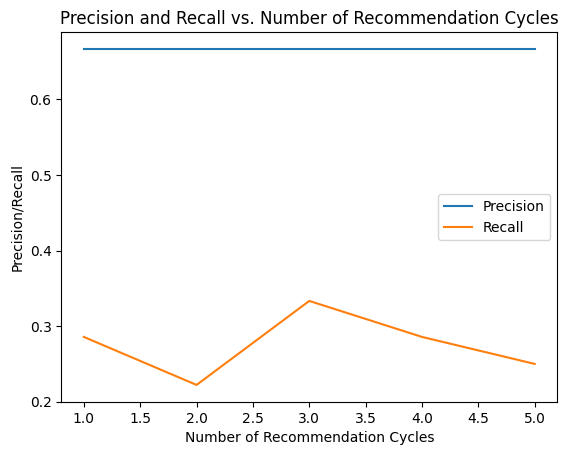

0.6666664444445185
0.2753967867709176


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split




class RecommenderLSTM:
    def __init__(self, num_users, num_items, embedding_dim):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

    def build_model(self):
        user_input = keras.Input(shape=(1,))
        item_input = keras.Input(shape=(1,))

        user_embedding = keras.layers.Embedding(self.num_users, self.embedding_dim)(user_input)
        item_embedding = keras.layers.Embedding(self.num_items, self.embedding_dim)(item_input)

        user_embedding = keras.layers.Flatten()(user_embedding)
        item_embedding = keras.layers.Flatten()(item_embedding)

        merged = keras.layers.Concatenate()([user_embedding, item_embedding])
        rnn_output = keras.layers.Dense(self.embedding_dim)(merged)
        output = keras.layers.Dense(10, activation='softmax')(rnn_output)

        model = keras.Model(inputs=[user_input, item_input], outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def train(self, train_data, epochs, batch_size):
        user_ids = train_data['user_id'].values - 1
        item_ids = train_data['item_id'].values - 1
        ratings = train_data['rating'].values

        user_train, user_val, item_train, item_val, rating_train, rating_val = train_test_split(
            user_ids, item_ids, ratings, test_size=0.2, random_state=42
        )
        train_labels_onehot = to_categorical(rating_train, num_classes=10)
        val_labels_onehot = to_categorical(rating_val, num_classes=10)

        model = self.build_model()

        model.fit([user_train, item_train], train_labels_onehot, epochs=epochs, batch_size=batch_size,
                  validation_data=([user_val, item_val],  val_labels_onehot))

        return model

    def recommend(self, user_id, model, top_n):
        user_ids = np.full(self.num_items, user_id - 1)
        item_ids = np.arange(self.num_items)

        predictions = model.predict([user_ids, item_ids]).flatten()

        top_indices = np.argsort(predictions)[::-1][:top_n]
        top_items = top_indices + 1  # Add 1 to adjust for 0-based indexing

        return top_items

class RecommenderSystem:
    def __init__(self, num_users, num_items):
        self.user_item_matrix = np.zeros((num_users, num_items))
        self.weights = np.zeros(num_items)
        self.user_preferences = np.zeros(num_items)

    def train(self, train_data, seed_item):
        for _, row in train_data.iterrows():
            user = row['user_id'] - 1
            item = row['item_id'] - 1
            rating = row['rating']
            self.user_item_matrix[user, item] = rating

        self.reweight(seed_item, [], 'Similarity-Mean')

    def update_user_preferences(self, user, item, rating):
        self.user_preferences[item] = rating
        self.reweight(item, [], 'Similarity-Mean')  # Update weights based on the new preference

    def recommend(self, seed_item, candidate_items, n):
        scores = np.zeros(len(candidate_items))

        for i, item in enumerate(candidate_items):
            overlap = self.calculate_overlap(seed_item, item)
            scores[i] = (1 - 0.5) * overlap + 0.5 * (overlap / len(candidate_items))

        sorted_indices = np.argsort(scores)[::-1]
        recommendations = [candidate_items[idx] for idx in sorted_indices[:n]]
        return recommendations

    def update_weights(self, seed_item, rejected_items, reweighting_policy):
        for item in rejected_items:
            if reweighting_policy == 'Directional':
                self.weights[item] += self.calculate_directional_delta(seed_item, item)
            elif reweighting_policy == 'Similarity':
                self.weights[item] += self.calculate_similarity_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Mean':
                self.weights[item] += self.calculate_similarity_mean_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Max':
                self.weights[item] += self.calculate_similarity_max_delta(seed_item, item)
            elif reweighting_policy == 'Recency':
                self.weights[item] += self.calculate_recency_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Mean':
                self.weights[item] += self.calculate_recency_mean_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Max':
                self.weights[item] += self.calculate_recency_max_delta(seed_item, item, len(rejected_items))

    def calculate_overlap(self, item1, item2):
        return np.dot(self.user_item_matrix[:, item1], self.user_item_matrix[:, item2])

    def calculate_directional_delta(self, seed_item, item):
        return self.calculate_overlap(seed_item, item)

    def calculate_similarity_delta(self, seed_item, item):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity * self.calculate_overlap(seed_item, item)

    def calculate_similarity_mean_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - mean_similarity

    def calculate_similarity_max_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - max_similarity

    def calculate_recency_delta(self, seed_item, item, depth):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity / depth - self.calculate_overlap(item, item)

    def calculate_recency_mean_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - mean_similarity

    def calculate_recency_max_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - max_similarity

    def reweight(self, seed_item, rejected_items, reweighting_policy):
        self.update_weights(seed_item, rejected_items, reweighting_policy)

    def generate_user_profile(self, user_id):
        user_ratings = self.user_item_matrix[user_id]
        liked_items = np.where(user_ratings > 3)[0]
        disliked_items = np.where(user_ratings < 3)[0]
        return liked_items, disliked_items


    def generate_recommendations(self, user_id, num_recommendation_cycles, num_recommendations):
      liked_items, disliked_items = self.generate_user_profile(user_id)
      seed_item = np.random.choice(liked_items)
      print(f"Seed item: {seed_item + 1}")

      data_path = '/content/u.data'
      columns = ['user_id', 'item_id', 'rating', 'timestamp']
      train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)

      # Define parameters
      num_users = train_data['user_id'].nunique()
      num_items = train_data['item_id'].nunique()
      embedding_dim = 32
      epochs = 10
      batch_size = 32
      num_recommendation_cycles = 5
      num_recommendations = 3
      selected_user_id = 22

      # Create and train the recommender LSTM
      recommender_lstm = RecommenderLSTM(num_users, num_items, embedding_dim)
      model = recommender_lstm.train(train_data, epochs, batch_size)

      # Generate recommendations for a specific user
      recommended_items = []
      for cycle in range(num_recommendation_cycles):
          recommendations = recommender_lstm.recommend(selected_user_id, model, num_recommendations)
          # print(f"Cycle {cycle + 1} Recommendations: {recommendations}")
          recommended_items.extend(recommendations)
          # Update user preferences and retrain the model if needed
          # ...

      recommended_items = recommended_items[:num_recommendation_cycles * num_recommendations]
      return recommended_items



    def evaluate_recommendation_quality(self, test_data, user_id, num_recommendation_cycles, num_recommendations):
        precision_list = []
        recall_list = []

        for _ in range(num_recommendation_cycles):
            liked_items, _ = self.generate_user_profile(user_id)
            seed_item = np.random.choice(liked_items)

            relevant_items = []

            for _ in range(num_recommendation_cycles):
                candidate_items = np.setdiff1d(liked_items, [seed_item])
                recommendations = self.recommend(seed_item, candidate_items, num_recommendations)
                relevant_items.extend(recommendations)
                seed_item = np.random.choice(np.setdiff1d(candidate_items, recommendations))

            relevant_items = list(set(relevant_items))
            recommended_items = self.recommend(seed_item, liked_items, num_recommendations)

            true_positives = len(set(recommended_items).intersection(relevant_items))
            false_positives = len(recommended_items) - true_positives
            false_negatives = len(relevant_items) - true_positives

            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)

            precision_list.append(precision)
            recall_list.append(recall)

        return precision_list, recall_list

# Example usage
def main():
    # Load data


    data_path = '/content/u.data'
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    test_data= train_data.sample(frac=0.2, random_state=42) # Sample test data



    # Define parameters
    num_users = train_data['user_id'].nunique()
    num_items = train_data['item_id'].nunique()
    num_recommendation_cycles = 5
    num_recommendations = 3

    # Create and train the recommender system
    recommender = RecommenderSystem(num_users, num_items)
    recommender.train(train_data, seed_item=1)

    # Generate recommendations for a specific user
    user_id = 22
    recommender.generate_recommendations(user_id, num_recommendation_cycles, num_recommendations)

    # Evaluate recommendation quality
    precision_list, recall_list = recommender.evaluate_recommendation_quality(test_data, user_id,
                                                                              num_recommendation_cycles,
                                                                              num_recommendations)

    # Print precision and recall for each cycle
    for i in range(num_recommendation_cycles):
        print(f"Cycle {i + 1} - Precision: {precision_list[i]}, Recall: {recall_list[i]}")

    # Plot graph for number of recommendations cycle and precision/recall
    plt.plot(range(1, num_recommendation_cycles + 1), precision_list, label='Precision')
    plt.plot(range(1, num_recommendation_cycles + 1), recall_list, label='Recall')
    plt.xlabel('Number of Recommendation Cycles')
    plt.ylabel('Precision/Recall')
    plt.title('Precision and Recall vs. Number of Recommendation Cycles')
    plt.legend()
    plt.show()
    print(sum(precision_list)/5)
    print(sum(recall_list)/5)

if __name__ == '__main__':
    main()


# 0.25

Seed item: 705
Epoch 1/10
2500/2500 [==============================] - 5s 2ms/step - loss: 1.3359 - accuracy: 0.4155 - val_loss: 1.2596 - val_accuracy: 0.4436
Epoch 2/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2345 - accuracy: 0.4551 - val_loss: 1.2570 - val_accuracy: 0.4435
Epoch 3/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2185 - accuracy: 0.4626 - val_loss: 1.2621 - val_accuracy: 0.4406
Epoch 4/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2104 - accuracy: 0.4665 - val_loss: 1.2656 - val_accuracy: 0.4387
Epoch 5/10
2500/2500 [==============================] - 4s 1ms/step - loss: 1.2045 - accuracy: 0.4688 - val_loss: 1.2679 - val_accuracy: 0.4337
Epoch 6/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2005 - accuracy: 0.4718 - val_loss: 1.2680 - val_accuracy: 0.4393
Epoch 7/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.1969 - accuracy: 0.4736 - val_loss: 1.2676 

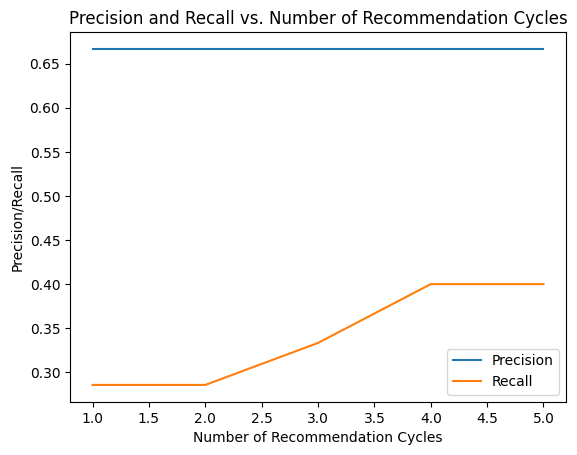

0.6666664444445185
0.34095232151474975


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split




class RecommenderLSTM:
    def __init__(self, num_users, num_items, embedding_dim):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

    def build_model(self):
        user_input = keras.Input(shape=(1,))
        item_input = keras.Input(shape=(1,))

        user_embedding = keras.layers.Embedding(self.num_users, self.embedding_dim)(user_input)
        item_embedding = keras.layers.Embedding(self.num_items, self.embedding_dim)(item_input)

        user_embedding = keras.layers.Flatten()(user_embedding)
        item_embedding = keras.layers.Flatten()(item_embedding)

        merged = keras.layers.Concatenate()([user_embedding, item_embedding])
        rnn_output = keras.layers.Dense(self.embedding_dim)(merged)
        output = keras.layers.Dense(10, activation='softmax')(rnn_output)

        model = keras.Model(inputs=[user_input, item_input], outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def train(self, train_data, epochs, batch_size):
        user_ids = train_data['user_id'].values - 1
        item_ids = train_data['item_id'].values - 1
        ratings = train_data['rating'].values

        user_train, user_val, item_train, item_val, rating_train, rating_val = train_test_split(
            user_ids, item_ids, ratings, test_size=0.2, random_state=42
        )
        train_labels_onehot = to_categorical(rating_train, num_classes=10)
        val_labels_onehot = to_categorical(rating_val, num_classes=10)

        model = self.build_model()

        model.fit([user_train, item_train], train_labels_onehot, epochs=epochs, batch_size=batch_size,
                  validation_data=([user_val, item_val],  val_labels_onehot))

        return model

    def recommend(self, user_id, model, top_n):
        user_ids = np.full(self.num_items, user_id - 1)
        item_ids = np.arange(self.num_items)

        predictions = model.predict([user_ids, item_ids]).flatten()

        top_indices = np.argsort(predictions)[::-1][:top_n]
        top_items = top_indices + 1  # Add 1 to adjust for 0-based indexing

        return top_items

class RecommenderSystem:
    def __init__(self, num_users, num_items):
        self.user_item_matrix = np.zeros((num_users, num_items))
        self.weights = np.zeros(num_items)
        self.user_preferences = np.zeros(num_items)

    def train(self, train_data, seed_item):
        for _, row in train_data.iterrows():
            user = row['user_id'] - 1
            item = row['item_id'] - 1
            rating = row['rating']
            self.user_item_matrix[user, item] = rating

        self.reweight(seed_item, [], 'Similarity-Mean')

    def update_user_preferences(self, user, item, rating):
        self.user_preferences[item] = rating
        self.reweight(item, [], 'Similarity-Mean')  # Update weights based on the new preference

    def recommend(self, seed_item, candidate_items, n):
        scores = np.zeros(len(candidate_items))

        for i, item in enumerate(candidate_items):
            overlap = self.calculate_overlap(seed_item, item)
            scores[i] = (1 - 0.25) * overlap + 0.25 * (overlap / len(candidate_items))

        sorted_indices = np.argsort(scores)[::-1]
        recommendations = [candidate_items[idx] for idx in sorted_indices[:n]]
        return recommendations

    def update_weights(self, seed_item, rejected_items, reweighting_policy):
        for item in rejected_items:
            if reweighting_policy == 'Directional':
                self.weights[item] += self.calculate_directional_delta(seed_item, item)
            elif reweighting_policy == 'Similarity':
                self.weights[item] += self.calculate_similarity_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Mean':
                self.weights[item] += self.calculate_similarity_mean_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Max':
                self.weights[item] += self.calculate_similarity_max_delta(seed_item, item)
            elif reweighting_policy == 'Recency':
                self.weights[item] += self.calculate_recency_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Mean':
                self.weights[item] += self.calculate_recency_mean_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Max':
                self.weights[item] += self.calculate_recency_max_delta(seed_item, item, len(rejected_items))

    def calculate_overlap(self, item1, item2):
        return np.dot(self.user_item_matrix[:, item1], self.user_item_matrix[:, item2])

    def calculate_directional_delta(self, seed_item, item):
        return self.calculate_overlap(seed_item, item)

    def calculate_similarity_delta(self, seed_item, item):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity * self.calculate_overlap(seed_item, item)

    def calculate_similarity_mean_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - mean_similarity

    def calculate_similarity_max_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - max_similarity

    def calculate_recency_delta(self, seed_item, item, depth):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity / depth - self.calculate_overlap(item, item)

    def calculate_recency_mean_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - mean_similarity

    def calculate_recency_max_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - max_similarity

    def reweight(self, seed_item, rejected_items, reweighting_policy):
        self.update_weights(seed_item, rejected_items, reweighting_policy)

    def generate_user_profile(self, user_id):
        user_ratings = self.user_item_matrix[user_id]
        liked_items = np.where(user_ratings > 3)[0]
        disliked_items = np.where(user_ratings < 3)[0]
        return liked_items, disliked_items


    def generate_recommendations(self, user_id, num_recommendation_cycles, num_recommendations):
      liked_items, disliked_items = self.generate_user_profile(user_id)
      seed_item = np.random.choice(liked_items)
      print(f"Seed item: {seed_item + 1}")

      data_path = '/content/u.data'
      columns = ['user_id', 'item_id', 'rating', 'timestamp']
      train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)

      # Define parameters
      num_users = train_data['user_id'].nunique()
      num_items = train_data['item_id'].nunique()
      embedding_dim = 32
      epochs = 10
      batch_size = 32
      num_recommendation_cycles = 5
      num_recommendations = 3
      selected_user_id = 22

      # Create and train the recommender LSTM
      recommender_lstm = RecommenderLSTM(num_users, num_items, embedding_dim)
      model = recommender_lstm.train(train_data, epochs, batch_size)

      # Generate recommendations for a specific user
      recommended_items = []
      for cycle in range(num_recommendation_cycles):
          recommendations = recommender_lstm.recommend(selected_user_id, model, num_recommendations)
          # print(f"Cycle {cycle + 1} Recommendations: {recommendations}")
          recommended_items.extend(recommendations)
          # Update user preferences and retrain the model if needed
          # ...

      recommended_items = recommended_items[:num_recommendation_cycles * num_recommendations]
      return recommended_items



    def evaluate_recommendation_quality(self, test_data, user_id, num_recommendation_cycles, num_recommendations):
        precision_list = []
        recall_list = []

        for _ in range(num_recommendation_cycles):
            liked_items, _ = self.generate_user_profile(user_id)
            seed_item = np.random.choice(liked_items)

            relevant_items = []

            for _ in range(num_recommendation_cycles):
                candidate_items = np.setdiff1d(liked_items, [seed_item])
                recommendations = self.recommend(seed_item, candidate_items, num_recommendations)
                relevant_items.extend(recommendations)
                seed_item = np.random.choice(np.setdiff1d(candidate_items, recommendations))

            relevant_items = list(set(relevant_items))
            recommended_items = self.recommend(seed_item, liked_items, num_recommendations)

            true_positives = len(set(recommended_items).intersection(relevant_items))
            false_positives = len(recommended_items) - true_positives
            false_negatives = len(relevant_items) - true_positives

            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)

            precision_list.append(precision)
            recall_list.append(recall)

        return precision_list, recall_list

# Example usage
def main():
    # Load data


    data_path = '/content/u.data'
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    test_data= train_data.sample(frac=0.2, random_state=42) # Sample test data



    # Define parameters
    num_users = train_data['user_id'].nunique()
    num_items = train_data['item_id'].nunique()
    num_recommendation_cycles = 5
    num_recommendations = 3

    # Create and train the recommender system
    recommender = RecommenderSystem(num_users, num_items)
    recommender.train(train_data, seed_item=1)

    # Generate recommendations for a specific user
    user_id = 22
    recommender.generate_recommendations(user_id, num_recommendation_cycles, num_recommendations)

    # Evaluate recommendation quality
    precision_list, recall_list = recommender.evaluate_recommendation_quality(test_data, user_id,
                                                                              num_recommendation_cycles,
                                                                              num_recommendations)

    # Print precision and recall for each cycle
    for i in range(num_recommendation_cycles):
        print(f"Cycle {i + 1} - Precision: {precision_list[i]}, Recall: {recall_list[i]}")

    # Plot graph for number of recommendations cycle and precision/recall
    plt.plot(range(1, num_recommendation_cycles + 1), precision_list, label='Precision')
    plt.plot(range(1, num_recommendation_cycles + 1), recall_list, label='Recall')
    plt.xlabel('Number of Recommendation Cycles')
    plt.ylabel('Precision/Recall')
    plt.title('Precision and Recall vs. Number of Recommendation Cycles')
    plt.legend()
    plt.show()
    print(sum(precision_list)/5)
    print(sum(recall_list)/5)

if __name__ == '__main__':
    main()


# 0

Seed item: 175
Epoch 1/10
2500/2500 [==============================] - 5s 2ms/step - loss: 1.3374 - accuracy: 0.4149 - val_loss: 1.2584 - val_accuracy: 0.4417
Epoch 2/10
2500/2500 [==============================] - 5s 2ms/step - loss: 1.2338 - accuracy: 0.4557 - val_loss: 1.2600 - val_accuracy: 0.4403
Epoch 3/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2186 - accuracy: 0.4642 - val_loss: 1.2651 - val_accuracy: 0.4345
Epoch 4/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2109 - accuracy: 0.4667 - val_loss: 1.2618 - val_accuracy: 0.4424
Epoch 5/10
2500/2500 [==============================] - 5s 2ms/step - loss: 1.2056 - accuracy: 0.4698 - val_loss: 1.2648 - val_accuracy: 0.4388
Epoch 6/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2017 - accuracy: 0.4702 - val_loss: 1.2649 - val_accuracy: 0.4385
Epoch 7/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.1982 - accuracy: 0.4728 - val_loss: 1.2688 

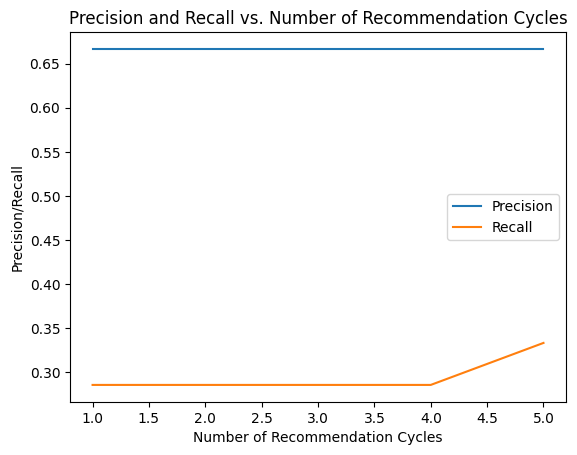

0.6666664444445185
0.2952380514739294


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split




class RecommenderLSTM:
    def __init__(self, num_users, num_items, embedding_dim):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

    def build_model(self):
        user_input = keras.Input(shape=(1,))
        item_input = keras.Input(shape=(1,))

        user_embedding = keras.layers.Embedding(self.num_users, self.embedding_dim)(user_input)
        item_embedding = keras.layers.Embedding(self.num_items, self.embedding_dim)(item_input)

        user_embedding = keras.layers.Flatten()(user_embedding)
        item_embedding = keras.layers.Flatten()(item_embedding)

        merged = keras.layers.Concatenate()([user_embedding, item_embedding])
        rnn_output = keras.layers.Dense(self.embedding_dim)(merged)
        output = keras.layers.Dense(10, activation='softmax')(rnn_output)

        model = keras.Model(inputs=[user_input, item_input], outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def train(self, train_data, epochs, batch_size):
        user_ids = train_data['user_id'].values - 1
        item_ids = train_data['item_id'].values - 1
        ratings = train_data['rating'].values

        user_train, user_val, item_train, item_val, rating_train, rating_val = train_test_split(
            user_ids, item_ids, ratings, test_size=0.2, random_state=42
        )
        train_labels_onehot = to_categorical(rating_train, num_classes=10)
        val_labels_onehot = to_categorical(rating_val, num_classes=10)

        model = self.build_model()

        model.fit([user_train, item_train], train_labels_onehot, epochs=epochs, batch_size=batch_size,
                  validation_data=([user_val, item_val],  val_labels_onehot))

        return model

    def recommend(self, user_id, model, top_n):
        user_ids = np.full(self.num_items, user_id - 1)
        item_ids = np.arange(self.num_items)

        predictions = model.predict([user_ids, item_ids]).flatten()

        top_indices = np.argsort(predictions)[::-1][:top_n]
        top_items = top_indices + 1  # Add 1 to adjust for 0-based indexing

        return top_items

class RecommenderSystem:
    def __init__(self, num_users, num_items):
        self.user_item_matrix = np.zeros((num_users, num_items))
        self.weights = np.zeros(num_items)
        self.user_preferences = np.zeros(num_items)

    def train(self, train_data, seed_item):
        for _, row in train_data.iterrows():
            user = row['user_id'] - 1
            item = row['item_id'] - 1
            rating = row['rating']
            self.user_item_matrix[user, item] = rating

        self.reweight(seed_item, [], 'Similarity-Mean')

    def update_user_preferences(self, user, item, rating):
        self.user_preferences[item] = rating
        self.reweight(item, [], 'Similarity-Mean')  # Update weights based on the new preference

    def recommend(self, seed_item, candidate_items, n):
        scores = np.zeros(len(candidate_items))

        for i, item in enumerate(candidate_items):
            overlap = self.calculate_overlap(seed_item, item)
            scores[i] = (1 - 0) * overlap + 0 * (overlap / len(candidate_items))

        sorted_indices = np.argsort(scores)[::-1]
        recommendations = [candidate_items[idx] for idx in sorted_indices[:n]]
        return recommendations

    def update_weights(self, seed_item, rejected_items, reweighting_policy):
        for item in rejected_items:
            if reweighting_policy == 'Directional':
                self.weights[item] += self.calculate_directional_delta(seed_item, item)
            elif reweighting_policy == 'Similarity':
                self.weights[item] += self.calculate_similarity_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Mean':
                self.weights[item] += self.calculate_similarity_mean_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Max':
                self.weights[item] += self.calculate_similarity_max_delta(seed_item, item)
            elif reweighting_policy == 'Recency':
                self.weights[item] += self.calculate_recency_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Mean':
                self.weights[item] += self.calculate_recency_mean_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Max':
                self.weights[item] += self.calculate_recency_max_delta(seed_item, item, len(rejected_items))

    def calculate_overlap(self, item1, item2):
        return np.dot(self.user_item_matrix[:, item1], self.user_item_matrix[:, item2])

    def calculate_directional_delta(self, seed_item, item):
        return self.calculate_overlap(seed_item, item)

    def calculate_similarity_delta(self, seed_item, item):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity * self.calculate_overlap(seed_item, item)

    def calculate_similarity_mean_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - mean_similarity

    def calculate_similarity_max_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - max_similarity

    def calculate_recency_delta(self, seed_item, item, depth):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity / depth - self.calculate_overlap(item, item)

    def calculate_recency_mean_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - mean_similarity

    def calculate_recency_max_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - max_similarity

    def reweight(self, seed_item, rejected_items, reweighting_policy):
        self.update_weights(seed_item, rejected_items, reweighting_policy)

    def generate_user_profile(self, user_id):
        user_ratings = self.user_item_matrix[user_id]
        liked_items = np.where(user_ratings > 3)[0]
        disliked_items = np.where(user_ratings < 3)[0]
        return liked_items, disliked_items


    def generate_recommendations(self, user_id, num_recommendation_cycles, num_recommendations):
      liked_items, disliked_items = self.generate_user_profile(user_id)
      seed_item = np.random.choice(liked_items)
      print(f"Seed item: {seed_item + 1}")

      data_path = '/content/u.data'
      columns = ['user_id', 'item_id', 'rating', 'timestamp']
      train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)

      # Define parameters
      num_users = train_data['user_id'].nunique()
      num_items = train_data['item_id'].nunique()
      embedding_dim = 32
      epochs = 10
      batch_size = 32
      num_recommendation_cycles = 5
      num_recommendations = 3
      selected_user_id = 22

      # Create and train the recommender LSTM
      recommender_lstm = RecommenderLSTM(num_users, num_items, embedding_dim)
      model = recommender_lstm.train(train_data, epochs, batch_size)

      # Generate recommendations for a specific user
      recommended_items = []
      for cycle in range(num_recommendation_cycles):
          recommendations = recommender_lstm.recommend(selected_user_id, model, num_recommendations)
          # print(f"Cycle {cycle + 1} Recommendations: {recommendations}")
          recommended_items.extend(recommendations)
          # Update user preferences and retrain the model if needed
          # ...

      recommended_items = recommended_items[:num_recommendation_cycles * num_recommendations]
      return recommended_items



    def evaluate_recommendation_quality(self, test_data, user_id, num_recommendation_cycles, num_recommendations):
        precision_list = []
        recall_list = []

        for _ in range(num_recommendation_cycles):
            liked_items, _ = self.generate_user_profile(user_id)
            seed_item = np.random.choice(liked_items)

            relevant_items = []

            for _ in range(num_recommendation_cycles):
                candidate_items = np.setdiff1d(liked_items, [seed_item])
                recommendations = self.recommend(seed_item, candidate_items, num_recommendations)
                relevant_items.extend(recommendations)
                seed_item = np.random.choice(np.setdiff1d(candidate_items, recommendations))

            relevant_items = list(set(relevant_items))
            recommended_items = self.recommend(seed_item, liked_items, num_recommendations)

            true_positives = len(set(recommended_items).intersection(relevant_items))
            false_positives = len(recommended_items) - true_positives
            false_negatives = len(relevant_items) - true_positives

            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)

            precision_list.append(precision)
            recall_list.append(recall)

        return precision_list, recall_list

# Example usage
def main():
    # Load data


    data_path = '/content/u.data'
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    test_data= train_data.sample(frac=0.2, random_state=42) # Sample test data



    # Define parameters
    num_users = train_data['user_id'].nunique()
    num_items = train_data['item_id'].nunique()
    num_recommendation_cycles = 5
    num_recommendations = 3

    # Create and train the recommender system
    recommender = RecommenderSystem(num_users, num_items)
    recommender.train(train_data, seed_item=1)

    # Generate recommendations for a specific user
    user_id = 22
    recommender.generate_recommendations(user_id, num_recommendation_cycles, num_recommendations)

    # Evaluate recommendation quality
    precision_list, recall_list = recommender.evaluate_recommendation_quality(test_data, user_id,
                                                                              num_recommendation_cycles,
                                                                              num_recommendations)

    # Print precision and recall for each cycle
    for i in range(num_recommendation_cycles):
        print(f"Cycle {i + 1} - Precision: {precision_list[i]}, Recall: {recall_list[i]}")

    # Plot graph for number of recommendations cycle and precision/recall
    plt.plot(range(1, num_recommendation_cycles + 1), precision_list, label='Precision')
    plt.plot(range(1, num_recommendation_cycles + 1), recall_list, label='Recall')
    plt.xlabel('Number of Recommendation Cycles')
    plt.ylabel('Precision/Recall')
    plt.title('Precision and Recall vs. Number of Recommendation Cycles')
    plt.legend()
    plt.show()
    print(sum(precision_list)/5)
    print(sum(recall_list)/5)

if __name__ == '__main__':
    main()


# 1

Seed item: 427
Epoch 1/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.3359 - accuracy: 0.4192 - val_loss: 1.2621 - val_accuracy: 0.4435
Epoch 2/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.2352 - accuracy: 0.4543 - val_loss: 1.2574 - val_accuracy: 0.4433
Epoch 3/10
2500/2500 [==============================] - 6s 2ms/step - loss: 1.2189 - accuracy: 0.4640 - val_loss: 1.2606 - val_accuracy: 0.4410
Epoch 4/10
2500/2500 [==============================] - 7s 3ms/step - loss: 1.2102 - accuracy: 0.4669 - val_loss: 1.2631 - val_accuracy: 0.4401
Epoch 5/10
2500/2500 [==============================] - 6s 2ms/step - loss: 1.2054 - accuracy: 0.4706 - val_loss: 1.2645 - val_accuracy: 0.4405
Epoch 6/10
2500/2500 [==============================] - 5s 2ms/step - loss: 1.2009 - accuracy: 0.4717 - val_loss: 1.2650 - val_accuracy: 0.4383
Epoch 7/10
2500/2500 [==============================] - 4s 1ms/step - loss: 1.1980 - accuracy: 0.4723 - val_loss: 1.2682 

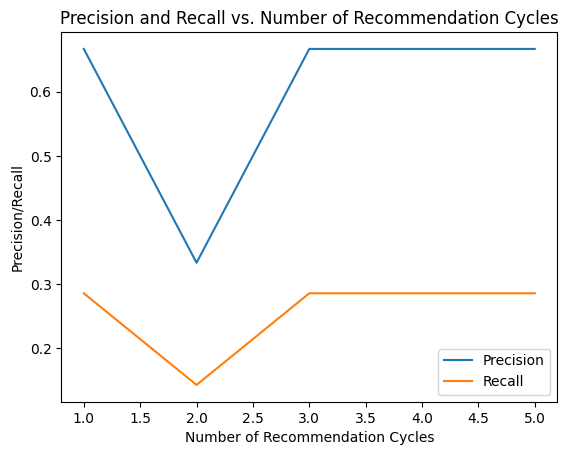

0.5999998000000668
0.2571428204081685


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split




class RecommenderLSTM:
    def __init__(self, num_users, num_items, embedding_dim):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

    def build_model(self):
        user_input = keras.Input(shape=(1,))
        item_input = keras.Input(shape=(1,))

        user_embedding = keras.layers.Embedding(self.num_users, self.embedding_dim)(user_input)
        item_embedding = keras.layers.Embedding(self.num_items, self.embedding_dim)(item_input)

        user_embedding = keras.layers.Flatten()(user_embedding)
        item_embedding = keras.layers.Flatten()(item_embedding)

        merged = keras.layers.Concatenate()([user_embedding, item_embedding])
        rnn_output = keras.layers.Dense(self.embedding_dim)(merged)
        output = keras.layers.Dense(10, activation='softmax')(rnn_output)

        model = keras.Model(inputs=[user_input, item_input], outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def train(self, train_data, epochs, batch_size):
        user_ids = train_data['user_id'].values - 1
        item_ids = train_data['item_id'].values - 1
        ratings = train_data['rating'].values

        user_train, user_val, item_train, item_val, rating_train, rating_val = train_test_split(
            user_ids, item_ids, ratings, test_size=0.2, random_state=42
        )
        train_labels_onehot = to_categorical(rating_train, num_classes=10)
        val_labels_onehot = to_categorical(rating_val, num_classes=10)

        model = self.build_model()

        model.fit([user_train, item_train], train_labels_onehot, epochs=epochs, batch_size=batch_size,
                  validation_data=([user_val, item_val],  val_labels_onehot))

        return model

    def recommend(self, user_id, model, top_n):
        user_ids = np.full(self.num_items, user_id - 1)
        item_ids = np.arange(self.num_items)

        predictions = model.predict([user_ids, item_ids]).flatten()

        top_indices = np.argsort(predictions)[::-1][:top_n]
        top_items = top_indices + 1  # Add 1 to adjust for 0-based indexing

        return top_items

class RecommenderSystem:
    def __init__(self, num_users, num_items):
        self.user_item_matrix = np.zeros((num_users, num_items))
        self.weights = np.zeros(num_items)
        self.user_preferences = np.zeros(num_items)

    def train(self, train_data, seed_item):
        for _, row in train_data.iterrows():
            user = row['user_id'] - 1
            item = row['item_id'] - 1
            rating = row['rating']
            self.user_item_matrix[user, item] = rating

        self.reweight(seed_item, [], 'Similarity-Mean')

    def update_user_preferences(self, user, item, rating):
        self.user_preferences[item] = rating
        self.reweight(item, [], 'Similarity-Mean')  # Update weights based on the new preference

    def recommend(self, seed_item, candidate_items, n):
        scores = np.zeros(len(candidate_items))

        for i, item in enumerate(candidate_items):
            overlap = self.calculate_overlap(seed_item, item)
            scores[i] = (1 - 1) * overlap + 1* (overlap / len(candidate_items))

        sorted_indices = np.argsort(scores)[::-1]
        recommendations = [candidate_items[idx] for idx in sorted_indices[:n]]
        return recommendations

    def update_weights(self, seed_item, rejected_items, reweighting_policy):
        for item in rejected_items:
            if reweighting_policy == 'Directional':
                self.weights[item] += self.calculate_directional_delta(seed_item, item)
            elif reweighting_policy == 'Similarity':
                self.weights[item] += self.calculate_similarity_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Mean':
                self.weights[item] += self.calculate_similarity_mean_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Max':
                self.weights[item] += self.calculate_similarity_max_delta(seed_item, item)
            elif reweighting_policy == 'Recency':
                self.weights[item] += self.calculate_recency_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Mean':
                self.weights[item] += self.calculate_recency_mean_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Max':
                self.weights[item] += self.calculate_recency_max_delta(seed_item, item, len(rejected_items))

    def calculate_overlap(self, item1, item2):
        return np.dot(self.user_item_matrix[:, item1], self.user_item_matrix[:, item2])

    def calculate_directional_delta(self, seed_item, item):
        return self.calculate_overlap(seed_item, item)

    def calculate_similarity_delta(self, seed_item, item):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity * self.calculate_overlap(seed_item, item)

    def calculate_similarity_mean_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - mean_similarity

    def calculate_similarity_max_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - max_similarity

    def calculate_recency_delta(self, seed_item, item, depth):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity / depth - self.calculate_overlap(item, item)

    def calculate_recency_mean_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - mean_similarity

    def calculate_recency_max_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - max_similarity

    def reweight(self, seed_item, rejected_items, reweighting_policy):
        self.update_weights(seed_item, rejected_items, reweighting_policy)

    def generate_user_profile(self, user_id):
        user_ratings = self.user_item_matrix[user_id]
        liked_items = np.where(user_ratings > 3)[0]
        disliked_items = np.where(user_ratings < 3)[0]
        return liked_items, disliked_items


    def generate_recommendations(self, user_id, num_recommendation_cycles, num_recommendations):
      liked_items, disliked_items = self.generate_user_profile(user_id)
      seed_item = np.random.choice(liked_items)
      print(f"Seed item: {seed_item + 1}")

      data_path = '/content/u.data'
      columns = ['user_id', 'item_id', 'rating', 'timestamp']
      train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)

      # Define parameters
      num_users = train_data['user_id'].nunique()
      num_items = train_data['item_id'].nunique()
      embedding_dim = 32
      epochs = 10
      batch_size = 32
      num_recommendation_cycles = 5
      num_recommendations = 3
      selected_user_id = 22

      # Create and train the recommender LSTM
      recommender_lstm = RecommenderLSTM(num_users, num_items, embedding_dim)
      model = recommender_lstm.train(train_data, epochs, batch_size)

      # Generate recommendations for a specific user
      recommended_items = []
      for cycle in range(num_recommendation_cycles):
          recommendations = recommender_lstm.recommend(selected_user_id, model, num_recommendations)
          # print(f"Cycle {cycle + 1} Recommendations: {recommendations}")
          recommended_items.extend(recommendations)
          # Update user preferences and retrain the model if needed
          # ...

      recommended_items = recommended_items[:num_recommendation_cycles * num_recommendations]
      return recommended_items



    def evaluate_recommendation_quality(self, test_data, user_id, num_recommendation_cycles, num_recommendations):
        precision_list = []
        recall_list = []

        for _ in range(num_recommendation_cycles):
            liked_items, _ = self.generate_user_profile(user_id)
            seed_item = np.random.choice(liked_items)

            relevant_items = []

            for _ in range(num_recommendation_cycles):
                candidate_items = np.setdiff1d(liked_items, [seed_item])
                recommendations = self.recommend(seed_item, candidate_items, num_recommendations)
                relevant_items.extend(recommendations)
                seed_item = np.random.choice(np.setdiff1d(candidate_items, recommendations))

            relevant_items = list(set(relevant_items))
            recommended_items = self.recommend(seed_item, liked_items, num_recommendations)

            true_positives = len(set(recommended_items).intersection(relevant_items))
            false_positives = len(recommended_items) - true_positives
            false_negatives = len(relevant_items) - true_positives

            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)

            precision_list.append(precision)
            recall_list.append(recall)

        return precision_list, recall_list

# Example usage
def main():
    # Load data


    data_path = '/content/u.data'
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    test_data= train_data.sample(frac=0.2, random_state=42) # Sample test data



    # Define parameters
    num_users = train_data['user_id'].nunique()
    num_items = train_data['item_id'].nunique()
    num_recommendation_cycles = 5
    num_recommendations = 3

    # Create and train the recommender system
    recommender = RecommenderSystem(num_users, num_items)
    recommender.train(train_data, seed_item=1)

    # Generate recommendations for a specific user
    user_id = 22
    recommender.generate_recommendations(user_id, num_recommendation_cycles, num_recommendations)

    # Evaluate recommendation quality
    precision_list, recall_list = recommender.evaluate_recommendation_quality(test_data, user_id,
                                                                              num_recommendation_cycles,
                                                                              num_recommendations)

    # Print precision and recall for each cycle
    for i in range(num_recommendation_cycles):
        print(f"Cycle {i + 1} - Precision: {precision_list[i]}, Recall: {recall_list[i]}")

    # Plot graph for number of recommendations cycle and precision/recall
    plt.plot(range(1, num_recommendation_cycles + 1), precision_list, label='Precision')
    plt.plot(range(1, num_recommendation_cycles + 1), recall_list, label='Recall')
    plt.xlabel('Number of Recommendation Cycles')
    plt.ylabel('Precision/Recall')
    plt.title('Precision and Recall vs. Number of Recommendation Cycles')
    plt.legend()
    plt.show()
    print(sum(precision_list)/5)
    print(sum(recall_list)/5)

if __name__ == '__main__':
    main()


#0.75

Seed item: 189
Epoch 1/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.3333 - accuracy: 0.4200 - val_loss: 1.2587 - val_accuracy: 0.4387
Epoch 2/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2341 - accuracy: 0.4564 - val_loss: 1.2565 - val_accuracy: 0.4414
Epoch 3/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2189 - accuracy: 0.4631 - val_loss: 1.2603 - val_accuracy: 0.4417
Epoch 4/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2106 - accuracy: 0.4672 - val_loss: 1.2618 - val_accuracy: 0.4416
Epoch 5/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.2048 - accuracy: 0.4701 - val_loss: 1.2676 - val_accuracy: 0.4386
Epoch 6/10
2500/2500 [==============================] - 4s 1ms/step - loss: 1.2010 - accuracy: 0.4715 - val_loss: 1.2688 - val_accuracy: 0.4399
Epoch 7/10
2500/2500 [==============================] - 4s 2ms/step - loss: 1.1974 - accuracy: 0.4728 - val_loss: 1.2688 

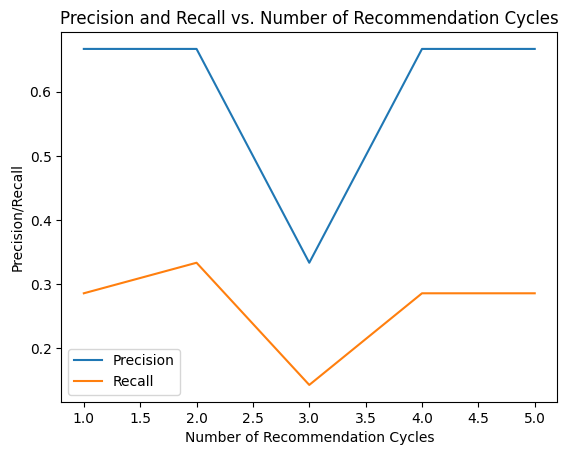

0.5999998000000668
0.2666666269841329


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split




class RecommenderLSTM:
    def __init__(self, num_users, num_items, embedding_dim):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

    def build_model(self):
        user_input = keras.Input(shape=(1,))
        item_input = keras.Input(shape=(1,))

        user_embedding = keras.layers.Embedding(self.num_users, self.embedding_dim)(user_input)
        item_embedding = keras.layers.Embedding(self.num_items, self.embedding_dim)(item_input)

        user_embedding = keras.layers.Flatten()(user_embedding)
        item_embedding = keras.layers.Flatten()(item_embedding)

        merged = keras.layers.Concatenate()([user_embedding, item_embedding])
        rnn_output = keras.layers.Dense(self.embedding_dim)(merged)
        output = keras.layers.Dense(10, activation='softmax')(rnn_output)

        model = keras.Model(inputs=[user_input, item_input], outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def train(self, train_data, epochs, batch_size):
        user_ids = train_data['user_id'].values - 1
        item_ids = train_data['item_id'].values - 1
        ratings = train_data['rating'].values

        user_train, user_val, item_train, item_val, rating_train, rating_val = train_test_split(
            user_ids, item_ids, ratings, test_size=0.2, random_state=42
        )
        train_labels_onehot = to_categorical(rating_train, num_classes=10)
        val_labels_onehot = to_categorical(rating_val, num_classes=10)

        model = self.build_model()

        model.fit([user_train, item_train], train_labels_onehot, epochs=epochs, batch_size=batch_size,
                  validation_data=([user_val, item_val],  val_labels_onehot))

        return model

    def recommend(self, user_id, model, top_n):
        user_ids = np.full(self.num_items, user_id - 1)
        item_ids = np.arange(self.num_items)

        predictions = model.predict([user_ids, item_ids]).flatten()

        top_indices = np.argsort(predictions)[::-1][:top_n]
        top_items = top_indices + 1  # Add 1 to adjust for 0-based indexing

        return top_items

class RecommenderSystem:
    def __init__(self, num_users, num_items):
        self.user_item_matrix = np.zeros((num_users, num_items))
        self.weights = np.zeros(num_items)
        self.user_preferences = np.zeros(num_items)

    def train(self, train_data, seed_item):
        for _, row in train_data.iterrows():
            user = row['user_id'] - 1
            item = row['item_id'] - 1
            rating = row['rating']
            self.user_item_matrix[user, item] = rating

        self.reweight(seed_item, [], 'Similarity-Mean')

    def update_user_preferences(self, user, item, rating):
        self.user_preferences[item] = rating
        self.reweight(item, [], 'Similarity-Mean')  # Update weights based on the new preference

    def recommend(self, seed_item, candidate_items, n):
        scores = np.zeros(len(candidate_items))

        for i, item in enumerate(candidate_items):
            overlap = self.calculate_overlap(seed_item, item)
            scores[i] = (1 - 0.75) * overlap + 0.75 * (overlap / len(candidate_items))

        sorted_indices = np.argsort(scores)[::-1]
        recommendations = [candidate_items[idx] for idx in sorted_indices[:n]]
        return recommendations

    def update_weights(self, seed_item, rejected_items, reweighting_policy):
        for item in rejected_items:
            if reweighting_policy == 'Directional':
                self.weights[item] += self.calculate_directional_delta(seed_item, item)
            elif reweighting_policy == 'Similarity':
                self.weights[item] += self.calculate_similarity_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Mean':
                self.weights[item] += self.calculate_similarity_mean_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Max':
                self.weights[item] += self.calculate_similarity_max_delta(seed_item, item)
            elif reweighting_policy == 'Recency':
                self.weights[item] += self.calculate_recency_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Mean':
                self.weights[item] += self.calculate_recency_mean_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Max':
                self.weights[item] += self.calculate_recency_max_delta(seed_item, item, len(rejected_items))

    def calculate_overlap(self, item1, item2):
        return np.dot(self.user_item_matrix[:, item1], self.user_item_matrix[:, item2])

    def calculate_directional_delta(self, seed_item, item):
        return self.calculate_overlap(seed_item, item)

    def calculate_similarity_delta(self, seed_item, item):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity * self.calculate_overlap(seed_item, item)

    def calculate_similarity_mean_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - mean_similarity

    def calculate_similarity_max_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - max_similarity

    def calculate_recency_delta(self, seed_item, item, depth):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity / depth - self.calculate_overlap(item, item)

    def calculate_recency_mean_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - mean_similarity

    def calculate_recency_max_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - max_similarity

    def reweight(self, seed_item, rejected_items, reweighting_policy):
        self.update_weights(seed_item, rejected_items, reweighting_policy)

    def generate_user_profile(self, user_id):
        user_ratings = self.user_item_matrix[user_id]
        liked_items = np.where(user_ratings > 3)[0]
        disliked_items = np.where(user_ratings < 3)[0]
        return liked_items, disliked_items


    def generate_recommendations(self, user_id, num_recommendation_cycles, num_recommendations):
      liked_items, disliked_items = self.generate_user_profile(user_id)
      seed_item = np.random.choice(liked_items)
      print(f"Seed item: {seed_item + 1}")

      data_path = '/content/u.data'
      columns = ['user_id', 'item_id', 'rating', 'timestamp']
      train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)

      # Define parameters
      num_users = train_data['user_id'].nunique()
      num_items = train_data['item_id'].nunique()
      embedding_dim = 32
      epochs = 10
      batch_size = 32
      num_recommendation_cycles = 5
      num_recommendations = 3
      selected_user_id = 22

      # Create and train the recommender LSTM
      recommender_lstm = RecommenderLSTM(num_users, num_items, embedding_dim)
      model = recommender_lstm.train(train_data, epochs, batch_size)

      # Generate recommendations for a specific user
      recommended_items = []
      for cycle in range(num_recommendation_cycles):
          recommendations = recommender_lstm.recommend(selected_user_id, model, num_recommendations)
          # print(f"Cycle {cycle + 1} Recommendations: {recommendations}")
          recommended_items.extend(recommendations)
          # Update user preferences and retrain the model if needed
          # ...

      recommended_items = recommended_items[:num_recommendation_cycles * num_recommendations]
      return recommended_items



    def evaluate_recommendation_quality(self, test_data, user_id, num_recommendation_cycles, num_recommendations):
        precision_list = []
        recall_list = []

        for _ in range(num_recommendation_cycles):
            liked_items, _ = self.generate_user_profile(user_id)
            seed_item = np.random.choice(liked_items)

            relevant_items = []

            for _ in range(num_recommendation_cycles):
                candidate_items = np.setdiff1d(liked_items, [seed_item])
                recommendations = self.recommend(seed_item, candidate_items, num_recommendations)
                relevant_items.extend(recommendations)
                seed_item = np.random.choice(np.setdiff1d(candidate_items, recommendations))

            relevant_items = list(set(relevant_items))
            recommended_items = self.recommend(seed_item, liked_items, num_recommendations)

            true_positives = len(set(recommended_items).intersection(relevant_items))
            false_positives = len(recommended_items) - true_positives
            false_negatives = len(relevant_items) - true_positives

            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)

            precision_list.append(precision)
            recall_list.append(recall)

        return precision_list, recall_list

# Example usage
def main():
    # Load data


    data_path = '/content/u.data'
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    test_data= train_data.sample(frac=0.2, random_state=42) # Sample test data



    # Define parameters
    num_users = train_data['user_id'].nunique()
    num_items = train_data['item_id'].nunique()
    num_recommendation_cycles = 5
    num_recommendations = 3

    # Create and train the recommender system
    recommender = RecommenderSystem(num_users, num_items)
    recommender.train(train_data, seed_item=1)

    # Generate recommendations for a specific user
    user_id = 22
    recommender.generate_recommendations(user_id, num_recommendation_cycles, num_recommendations)

    # Evaluate recommendation quality
    precision_list, recall_list = recommender.evaluate_recommendation_quality(test_data, user_id,
                                                                              num_recommendation_cycles,
                                                                              num_recommendations)

    # Print precision and recall for each cycle
    for i in range(num_recommendation_cycles):
        print(f"Cycle {i + 1} - Precision: {precision_list[i]}, Recall: {recall_list[i]}")

    # Plot graph for number of recommendations cycle and precision/recall
    plt.plot(range(1, num_recommendation_cycles + 1), precision_list, label='Precision')
    plt.plot(range(1, num_recommendation_cycles + 1), recall_list, label='Recall')
    plt.xlabel('Number of Recommendation Cycles')
    plt.ylabel('Precision/Recall')
    plt.title('Precision and Recall vs. Number of Recommendation Cycles')
    plt.legend()
    plt.show()
    print(sum(precision_list)/5)
    print(sum(recall_list)/5)

if __name__ == '__main__':
    main()
